In [1]:
from tqdm import tqdm
from pathlib import Path
import pickle
import os
import open3d as o3d # 0.14 has ray casting
import point_cloud_utils as pcu # !pip install pypcu
import csv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from PIL import Image

def boxpts_to_o3dbox(box_pts):
    boxpts = o3d.utility.Vector3dVector(box_pts)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    return o3dbox

def cylindrical2cart(points):
    r, azimuth, z = points[:,0], points[:,1], points[:,2]
    x = r*np.cos(azimuth)
    y = r*np.sin(azimuth)
    return np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]), axis=1)


def generate_ncoords_by_azimuth_bins(nbins=16, min_dist=5, max_dist=70, z_mu=0.8, z_sigma=0.3):
    azbin_size = 2*np.pi/nbins
    azbin_edges = [-np.pi+i*azbin_size for i in range(nbins+1)]

    cyl = []
    for i in range(nbins):
        rand_dist = np.random.uniform(min_dist,max_dist)
        az_bin = [azbin_edges[i], azbin_edges[i+1]]
        sampled_az = np.random.normal(np.mean(az_bin), azbin_size/4)
        cyl.append([rand_dist, sampled_az])

    z = np.random.normal(loc=z_mu, scale=z_sigma, size=[len(cyl)])
    return cylindrical2cart(np.hstack([np.array(cyl), z[...,np.newaxis]]))


def convert_to_o3dpcd(points, color=None):
    if type(points) == list:
        pcds = []
        for pointcloud in points:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pointcloud[:,:3])
            pcds.append(pcd)
        return pcds
    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:,:3])
        if color:
            pcd.paint_uniform_color(color)
        return pcd

def get_scaling_factor(pts, min_car_width=1.55, max_car_width=2.15, min_car_height=0.8):
    bounds = get_minmax(pts)
    dims = get_lwh(bounds)    
    
    valid_scaling = False
    while(not valid_scaling):
        car_width = np.random.uniform(min_car_width, max_car_width)
        scaling_factor = car_width/dims[1]
        scaled_pts = scaling_factor * pts
        scaled_bounds = get_minmax(scaled_pts)
        scaled_dims = get_lwh(scaled_bounds)
        if scaled_dims[2] > min_car_height:
            valid_scaling = True
    
    return scaling_factor    
    
    
def get_minmax(pts):
    return {'max_x':max(pts[:,0]), 'min_x':min(pts[:,0]),
            'max_y':max(pts[:,1]), 'min_y':min(pts[:,1]),
            'max_z':max(pts[:,2]), 'min_z':min(pts[:,2])}

def get_lwh(minmax):
    l1 = minmax['max_x'] - minmax['min_x']
    l2 = minmax['max_y'] - minmax['min_y']
    return np.array([max(l1,l2),min(l1,l2), minmax['max_z'] - minmax['min_z']]) # l,w,h

def get_gt_for_zero_yaw(pts, openpcdet_format=False, o3d_format=False):
    bounds = get_minmax(pts)     
    dims = get_lwh(bounds)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2])   

    # return 3d box points for o3d box construction
    bbox3d = np.array([
        [bounds['max_x'], bounds['max_y'], bounds['max_z']],
        [bounds['max_x'], bounds['min_y'], bounds['max_z']],
        [bounds['min_x'], bounds['max_y'], bounds['max_z']],
        [bounds['min_x'], bounds['min_y'], bounds['max_z']],
        [bounds['max_x'], bounds['max_y'], bounds['min_z']],
        [bounds['max_x'], bounds['min_y'], bounds['min_z']],
        [bounds['min_x'], bounds['max_y'], bounds['min_z']],
        [bounds['min_x'], bounds['min_y'], bounds['min_z']]
    ])
    if o3d_format:
        o3dvec_bbox = o3d.utility.Vector3dVector(bbox3d)
        o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dvec_bbox)
        o3dbox.color = np.array([1,0,0])
        return {'bbox':o3dbox, 'center':center, 'dims':dims} 
    else:
        return {'bbox':bbox3d, 'center':center, 'dims':dims} 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [43]:
scales_list = []
for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]   
    if len(car_label) > 0:
        valid_carwidth = (car_label[:,4] > 1.5) & (car_label[:,4] < 3)
        valid_carlength = (car_label[:,3] > 2.4) & (car_label[:,3] < 7)
        valid_mask = valid_carwidth & valid_carlength
        car_label = car_label[valid_mask]
        scales_list.append(car_label)
        
scales = np.vstack(scales_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [42]:
import pickle

infos_path = '/SEE-MTDA/data/waymo/infos_openpcdetv0.3.0/waymo_infos_train.pkl'

with open(infos_path, 'rb') as f:
    infos = pickle.load(f)

In [44]:
waymo_lidar_height = 2.4
frames = {}

fnum = 0
for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]     
    
    if len(car_label) > 0:
        frames[fnum] = {}
        frames[fnum]['car'] = {}
        frames[fnum]['sign'] = {}
        
        # Waymo annotates forklifts etc as two parts, the arm and body. We ignore the arm.
        valid_carwidth = car_label[:,4] > 1.5
        car_label = car_label[valid_carwidth]
        
        car_label[:,2] -= waymo_lidar_height    
        frames[fnum]['car']['label'] = car_label
        frames[fnum]['car']['num_pts'] = info['annos']['num_points_in_gt'][vmask]
        frames[fnum]['car']['num_obj'] = len(car_label)
    
        smask = info['annos']['name'] == 'Sign'
        sign_label = info['annos']['gt_boxes_lidar'][smask]   

        if len(sign_label) > 0:            
            sign_label[:,2] -= waymo_lidar_height
            frames[fnum]['sign']['label'] = sign_label
            frames[fnum]['sign']['num_pts'] = info['annos']['num_points_in_gt'][smask]
            frames[fnum]['sign']['num_obj'] = len(sign_label)
        fnum += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


31


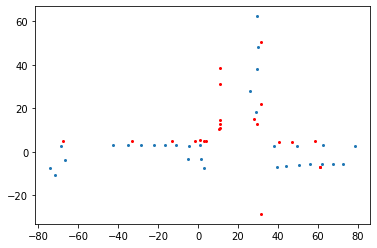

In [49]:
fnum = 396
print(frames[fnum]['car']['num_obj'])

plt.scatter(frames[fnum]['car']['label'][:,0], frames[fnum]['car']['label'][:,1], s=4)
plt.scatter(frames[fnum]['sign']['label'][:,0], frames[fnum]['sign']['label'][:,1], s=4, c='red')

In [48]:
fnum = 396
scene_boxes = [boxpts_to_o3dbox(gtbox_to_corners(frames[fnum]['car']['label'][i])) for i in range(len(frames[fnum]['car']['label']))]
o3d.visualization.draw_geometries(scene_boxes)

In [101]:
from pathlib import Path

def get_car_model(idx, model_filelist):
    if idx == -1:
        valid_model = False
        while(not valid_model):            
            model_idx = np.random.randint(0,len(model_filelist))
            obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'
            if obj_file.exists():
                return str(obj_file)
    else:
        obj_file = Path(model_filelist[idx] + '/models/model_normalized.obj')
        if not obj_file.exists():
            raise f"{str(obj_file)} does not exist"            
        else:
            return str(obj_file)
        
        
def get_random_car(model_filelist):
    """
    Returns a random model that is randomly scaled and rotated
    """
    obj_file = get_car_model(-1, model_filelist)
    
    obj = load_shapenet(obj_file)
    model_v = np.asarray(obj['mesh'].vertices)
    
    print(obj_file)
    alpha = get_scaling_factor(model_v)
    scaled_pts = alpha * model_v
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    obj_data = {'bbox': gtbox['bbox'],
                'vertices': scaled_pts,
                'faces': obj['mesh'].triangles,
                'centre': gtbox['center'],
                'dims': gtbox['dims'],
                'model_id': obj_file.split('/')[-3]}
    return obj_data

car = get_random_car(models)

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.52249196 1.84603086 1.32224429]


In [104]:
def get_tmesh_with_box_labels(box_label, model_filelist):
    car = get_random_car(model_filelist)
    centroid = box_label[:3]
    yaw = box_label[-1]
    rmat = np.array([[np.cos(yaw), np.sin(yaw), 0],
                      [-np.sin(yaw), np.cos(yaw), 0],
                      [0, 0, 1]])
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(car['vertices'] @ rmat.T + centroid)
    tmesh.triangles = o3d.utility.Vector3iVector(car['faces'])
    
    ret = {'bbox': car['bbox'] @ rmat.T + centroid, 
           'mesh': tmesh, 
           'model_id': car['model_id'],
           'label': list(centroid) + list(car['dims']) + list([yaw]),
           'waymo_num_pts': int(box_label[-1])} 
    return ret

scene_cars = [get_tmesh_with_box_labels(frames[fnum]['car']['label'][i], models) for i in range(len(frames[fnum]['car']['label']))]

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.00783643 2.04414307 1.46414481]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.04802656 2.06054823 1.47589523]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.08468752 1.66732396 1.19424309]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [3.8653455  1.57779099 1.1301139 ]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.11799161 2.08910718 1.49635096]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.5344858  1.85092661 1.32575094]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/029583

In [ ]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([sc['mesh'] for sc in scene_cars] + [origin])

In [63]:
def populate_scene(scene_cars, sign_labels, random_poles_pct=0.3):
    scene = o3d.t.geometry.RaycastingScene()
    
    num_rand_poles = int(len(scene_cars)*random_poles_pct)
    
    for i, sc in enumerate(scene_cars):
        tmesh = o3d.t.geometry.TriangleMesh.from_legacy(sc['mesh'])
        scene.add_triangles(tmesh)
        
        if i < num_rand_poles:
            # Obstacles that are close to the cars
            car_centre = sc['label'][:3]
            car_height = sc['label'][5]
            pole_radius = np.random.uniform(0.03,0.2)
            pole_height = np.random.uniform(1,4,1)

            box_min = np.min(sc['bbox'], axis=0)[:2]
            box_max = np.max(sc['bbox'], axis=0)[:2]
            xyall_choice = np.random.choice([1,2,3])
            if np.random.choice([True, False]):
                if xyall_choice == 1:                    
                    pole_xy = np.array([box_max[0], car_centre[1]]) + np.random.uniform(0,0.5)
                elif xyall_choice == 2: 
                    pole_xy = np.array([car_centre[0], box_max[1]]) + np.random.uniform(0,0.5)
                else:
                    pole_xy = box_max + np.random.uniform(0,1,2)
            else:
                pole_xy = box_min - np.random.uniform(0,1,2)        
            pole_centre = np.concatenate([pole_xy, np.array(car_centre[2] + pole_height/2 - car_height/2)])
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height.item()).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
    
    # Add the waymo labelled signs as cylinders
    for i, sign in enumerate(sign_labels):
        pole_height = np.random.uniform(1,4,1)
        pole_centre = sign[:3]
        pole_centre[2] = -2.4 + pole_height/2
        pole_radius = np.random.uniform(0.03,0.1)        
        cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height).translate(pole_centre)
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
                
    return scene

def cast_rays_at_point(scene, point, fov_deg=100, aspect_ratio=2, height_px=640):
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov_deg, # simulates a vertical fov of lidar
    center=point, # point where camera is looking at
    eye=[0,0,0], # position of the camera
    up=[0, 0, 1], # up vector
    width_px=aspect_ratio*height_px, # image width
    height_px=height_px, # image height
    )
    
    ans = scene.cast_rays(rays)
    hit = ans['t_hit'].isfinite()
    points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
    return points.numpy()
    
    
def raycast_object(car, scene):
    centre = car['label'][:3]
    ray_pts = cast_rays_at_point(scene, centre)
    o3dbox = boxpts_to_o3dbox(car['bbox'])
    
    ret = {'ray_pts': convert_to_o3dpcd(ray_pts),
           'obj_pts': convert_to_o3dpcd(ray_pts).crop(o3dbox),
           'bbox': o3dbox}
    return ret

scene = populate_scene(scene_cars, frames[fnum]['sign']['label'])
res = raycast_object(scene_cars[0], scene)

In [64]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([res['ray_pts'], res['bbox'], origin])

In [300]:
o3d.visualization.draw_geometries([res['obj_pts'], res['bbox'], origin])

In [180]:
sum([frames[i]['car']['num_obj'] for i in range(len(frames))])

4712401

# Export scenes

In [2]:
from pathlib import Path
import time

def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    obj = {}
    obj['model_id'] = obj_file.split('/')[-3]
    obj['sampled_pts'] = pts - center
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(v - center)
    tmesh.triangles = o3d.utility.Vector3iVector(f)
    obj['mesh'] = tmesh
    obj['dims'] = np.array([bounds['max_x']-bounds['min_x'],bounds['max_y']-bounds['min_y'],bounds['max_z']-bounds['min_z']])
    
    return obj

def get_scaling_factor(obj, min_car_width=1.55, max_car_width=2.15, min_car_height=0.6):
    dims = obj['dims']    
#     print(f'{model_id} - origdims = {dims}')
    valid_scaling = False
    while(not valid_scaling):
        car_width = np.random.uniform(min_car_width, max_car_width)
        scaling_factor = car_width/dims[1]
        scaled_pts = scaling_factor * np.asarray(obj['mesh'].vertices)
        scaled_bounds = get_minmax(scaled_pts)
        scaled_dims = get_lwh(scaled_bounds)
        if scaled_dims[2] > min_car_height:
            valid_scaling = True
    
    return scaling_factor    
    

def sample_car_model(data_dir, sampled_db, unseen_list):
    # Random sample. We pop unseen/seen after seeing all models once
    if len(unseen_list) > 0:
        db_idx = np.random.randint(0,len(unseen_list))
        model_id = unseen_list[db_idx]
        sampled_db.setdefault(model_id, 0)
        unseen_list.remove(model_id)
        
#         print(f'sampling db_idx: {db_idx}, model_id: {model_id} from {len(unseen_list)} models')
    else:
        # Get the least sampled model
        model_id = min(sampled_db, key=sampled_db.get)
#         print(f'sampling model_id: {model_id} with {sampled_db[model_id]} counts')
    
    sampled_db[model_id] += 1
    obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'    
    
    assert obj_file.exists(), f"{str(obj_file)} does not exist"    
    return str(obj_file)
        
        
def get_car_object(data_dir, sampled_db, unseen_list):
    """
    Returns a random model that is randomly scaled and rotated
    """
    obj_file = sample_car_model(data_dir, sampled_db, unseen_list)
    model_id = obj_file.split('/')[-3]

    obj = load_shapenet(obj_file)
    model_v = np.asarray(obj['mesh'].vertices)
    
    alpha = get_scaling_factor(obj)
    scaled_pts = alpha * model_v
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    obj_data = {'bbox': gtbox['bbox'],
                'vertices': scaled_pts,
                'faces': obj['mesh'].triangles,
                'centre': gtbox['center'],
                'dims': gtbox['dims'],
                'model_id': model_id}
    return obj_data

def get_tmeshes_with_box_labels(frame_cars, data_dir, sampled_db, unseen_list):
    if 'label' not in frame_cars:
        return []
    
    scene_cars = []
    for box_label in frame_cars['label']:

        car = get_car_object(data_dir, sampled_db, unseen_list)
        centroid = box_label[:3]
        yaw = box_label[-1]
        rmat = np.array([[np.cos(yaw), np.sin(yaw), 0],
                          [-np.sin(yaw), np.cos(yaw), 0],
                          [0, 0, 1]])
        tmesh = o3d.geometry.TriangleMesh()
        tmesh.vertices = o3d.utility.Vector3dVector(car['vertices'] @ rmat.T + centroid)
        tmesh.triangles = o3d.utility.Vector3iVector(car['faces'])

        ret = {'bbox': car['bbox'] @ rmat + centroid, 
               'mesh': tmesh, 
               'model_id': car['model_id'],
               'label': list(centroid) + list(car['dims']) + list([yaw]),
               'waymo_num_pts': int(box_label[-1])} 
        scene_cars.append(ret)
    return scene_cars

def opd_to_boxpts(box):
    """
    Takes an array containing [x,y,z,l,w,h,r], and returns an [8, 3] matrix that 
    represents the [x, y, z] for each 8 corners of the box.
    
    Note: Openpcdet __getitem__ gt_boxes are in the format [x,y,z,l,w,h,r,alpha]
    where alpha is "observation angle of object, ranging [-pi..pi]"
    """
    # To return
    corner_boxes = np.zeros((8, 3))

    translation = box[0:3]
    l, w, h = box[3], box[4], box[5] # waymo, nusc, kitti is all l,w,h after OpenPCDet processing
    rotation = box[6]

    # Create a bounding box outline
    bounding_box = np.array([[l/2, w/2, h/2],
                             [l/2, -w/2, h/2],
                             [-l/2, w/2, h/2],
                             [-l/2, -w/2, h/2],
                             [l/2, w/2, -h/2],
                             [l/2, -w/2, -h/2],
                             [-l/2, w/2, -h/2],
                             [-l/2, -w/2, -h/2]])

    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), np.sin(rotation), 0.0],
        [-np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])
    vcbox = bounding_box @ rotation_matrix
    vcbox += box[:3]
    
    return vcbox

In [3]:
def populate_scene(scene_cars, signs, random_poles_pct=0.3):
    scene = o3d.t.geometry.RaycastingScene()
    
    num_rand_poles = int(len(scene_cars)*random_poles_pct)
    
    for i, sc in enumerate(scene_cars):
        tmesh = o3d.t.geometry.TriangleMesh.from_legacy(sc['mesh'])
        scene.add_triangles(tmesh)
        
        if i < num_rand_poles:
            # Obstacles that are close to the cars
            car_centre = sc['label'][:3]
            car_height = sc['label'][5]
            pole_radius = np.random.uniform(0.03,0.2)
            pole_height = np.random.uniform(1,4,1)

            box_min = np.min(sc['bbox'], axis=0)[:2]
            box_max = np.max(sc['bbox'], axis=0)[:2]
            xyall_choice = np.random.choice([1,2,3])
            if np.random.choice([True, False]):
                if xyall_choice == 1:                    
                    pole_xy = np.array([box_max[0], car_centre[1]]) + np.random.uniform(0,0.5)
                elif xyall_choice == 2:
                    pole_xy = np.array([car_centre[0], box_max[1]]) + np.random.uniform(0,0.5)
                else:
                    pole_xy = box_max + np.random.uniform(0,1,2)
            else:
                pole_xy = box_min - np.random.uniform(0,1,2)        
            pole_centre = np.concatenate([pole_xy, np.array(car_centre[2] + pole_height/2 - car_height/2)])
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height.item()).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
    
    # Add the waymo labelled signs as cylinders
    if 'label' in signs:
        sign_labels = signs['label']
        for i, sign in enumerate(sign_labels):
            pole_height = np.random.uniform(1,4,1)
            pole_centre = sign[:3]
            pole_centre[2] = -2.4 + pole_height/2
            pole_radius = np.random.uniform(0.03,0.1)        
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
                
    return scene

def cast_rays_at_point(scene, point, fov_deg=100, aspect_ratio=2, height_px=640):
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov_deg, # simulates a vertical fov of lidar
    center=point, # point where camera is looking at
    eye=[0,0,0], # position of the camera
    up=[0, 0, 1], # up vector
    width_px=aspect_ratio*height_px, # image width
    height_px=height_px, # image height
    )
    
    ans = scene.cast_rays(rays)
    hit = ans['t_hit'].isfinite()
    points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
    return points.numpy()
    
    
def raycast_object(car, scene, npoints):
    centre = car['label'][:3]    
    
    fov_deg = np.random.normal(120, 30)
    ray_pts = cast_rays_at_point(scene, centre, fov_deg=fov_deg, aspect_ratio=2, height_px=640)
    o3dbox = boxpts_to_o3dbox(car['bbox'])
    
    ret = {'ray_pts': convert_to_o3dpcd(ray_pts),
           'obj_pts': convert_to_o3dpcd(ray_pts).crop(o3dbox),
           'complete': car['mesh'].sample_points_uniformly(npoints),
           'bbox_pts': car['bbox'],
           'model_id': car['model_id'],
           'label': car['label'],
           'fov_deg':fov_deg}
    return ret

In [4]:
waymo_lidar_height = 2.4
frames = []

infos_path = '/SEE-MTDA/data/waymo/infos_openpcdetv0.3.0/waymo_infos_train.pkl'

with open(infos_path, 'rb') as f:
    infos = pickle.load(f)

for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]     
    
    if len(car_label) > 0:
        frame = {}
        frame['car'] = {}
        frame['sign'] = {}
        
        # Waymo annotates forklifts etc as two parts, the arm and body. We ignore the arm.
        valid_carwidth = car_label[:,4] > 1.5
        car_label = car_label[valid_carwidth]
        
        car_label[:,2] -= waymo_lidar_height    
        frame['car']['label'] = car_label
        frame['car']['num_pts'] = info['annos']['num_points_in_gt'][vmask]
        frame['car']['num_obj'] = len(car_label)
    
        smask = info['annos']['name'] == 'Sign'
        sign_label = info['annos']['gt_boxes_lidar'][smask]   

        if len(sign_label) > 0:            
            sign_label[:,2] -= waymo_lidar_height
            frame['sign']['label'] = sign_label
            frame['sign']['num_pts'] = info['annos']['num_points_in_gt'][smask]
            frame['sign']['num_obj'] = len(sign_label)
        frames.append(frame)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


In [5]:
import pickle
import random

# Specifically for Shapenet.v2
ignore = {}
ignore['non_car'] = ['d353bf0e0dfe3ac29cbc1c09129e1507','c0db588c8c816cd2dc668d3d64c871ae']
ignore['unclean_car'] = ['a75ff576da012340468bac13e007a6e9','52c589e86fd500cd4a42886683bb52d2','65d6433043c40046b82c0841410a924f','e09813b03bdfce83a23218adb697420d','d1acd4916d3d3b57c48db2ed8f5e994c','39b307361b650db073a425eed3ac7a0b', 'dda10fc985eea0868c368040825ed335', '471673f3f062abd473f10e6caaeca56','e2ceb9bf23b498dda7431386d9d22644','3804a264b503d5812e40b8f7ac380eb5','445185842d893b6978fe949fc1419876','95ebb3fd80f885ad676f197a68a5168a','ba89184f58f21ff63343f5fadc4a2136']
ignore['truck_bus'] = ['6aa8f648cc8df63ab2c17ece4015d55','84bc3155bc5c95bfaaafd94b9f216ef6','fd3b75f7f1e9172fb6f657757c95f74e','21999849a6a8aad752470de2774d6099','dfa6c32dec07727ee9d8921ebe6d5b8e','26b7a9c6c7e74829eabc798aaf5f039f', '433481aa8cde9b692e3dd7c278f108dd','cdfe4dc408f4ca84aaafd94b9f216ef6']
ignore['limo'] = ['c9b49f7b355528e5632dc979097a3ec0','b11c0c16e0eed1f4b8671dc42cc45273','eefce52130d223ba2dcbf88f7c685079','db432e9f280ffb1e3dd4bdc1dbab98bd','dd0817b9757b74c75d3a87a5c4dd9ce4','e4b1de221f2d66352638397725e10cf9','9d2b7938d426633b28044fe9244db50a','41d317b520eec9d38d3d01fa03326bb0','5a5b0e1cbb38bdb12d08a76380360b3b','bc9c588a00ae179fa2645d665a7d8fa','ed91b2509171fdc1c48492b454f1615a','17c32e15723ed6e0cd0bf4a0e76b8df5','9fa56c19e4d54cca99c8d14f483ffc82','2f1001870f90e06bc48492b454f1615a','4c53afe560e36d8380ba2a9340bf2d77','e0978173fcfc5203510556e7c3123591','fb8adbcf67d858fc28044fe9244db50a','9dee0ea5da388102e6d91d458fe44a15','7c7e5b4fa56d8ed654b40bc735c6fdf6','7f6031f1738d52546436916a86a90ed7','cc0c058e2eca523051fb05589f6b0d0e','9676e8250cdd90307d5394224a6aa067','282293948b21262769416db9b743e50b','202fbaeffaf49f4b61c6c61410fc904b','b4d258dc5a12f9f7ade7f700b19bcf4a','f1b97d671bb93ad928044fe9244db50a','9d77d4c959974035fab60fc805223a73','5c3fe4057ef12b6886ac29addefc0f11','56dc27e4374cf87132eaaf3b7c9989f6', '501ac8493044eff04d44f5db04bf14b8','55181c34dadb4f032db09455d18fca0']
ignore['invalid_lwratio'] = ['7e7f0637d6798113ddb4014f0e8d0dac', '492a339ce5da3fe8e4b68d3b17c43658', '99fce87e4e80e053374462542bf2aa29', 'f7f7b1b4021be11afaeea7738551d104', 'bfa01c632be2eb06e8a3b392b986583', '7c85e6cf9c4f46e91cc13e432d5756b8', '6b79cfceb6f614527e7afb83f93db294', '52c589e86fd500cd4a42886683bb52d2', 'd1acd4916d3d3b57c48db2ed8f5e994c', '65d6433043c40046b82c0841410a924f', 'f4498022df553505c35f22936e5aea5c', '3c310afdf363201cefe5f291bc2f5fd0', 'c0db588c8c816cd2dc668d3d64c871ae', 'd353bf0e0dfe3ac29cbc1c09129e1507', '9f7b4a82becac9cd5568b8cbf53329df', 'e4d1edc4cda4a6445fb81d6394b59c19','c30bf6d1ae428497c7f3070d3c7b9f30', '3804a264b503d5812e40b8f7ac380eb5', 'cdfe4dc408f4ca84aaafd94b9f216ef6', '55181c34dadb4f032db09455d18fca0', '95a6e03656bdff26f69bc9777f9c3c39', '957a686c3c9f956a3d982653fc5fd75b', '88c884dd867d221984ae8a5736280c', 'ba89184f58f21ff63343f5fadc4a2136', '1c7ddd2735778013ce50f18f6100cef6', 'd05aa55f9e5b4d10afe1d4530f4c6e24', 'a3e7603c0d9ef56280e74058ee862f05', '96ca20dd7caff0bb851f021b9ed69c58', '2df225b8df2633c231141a7d4d06dc13', '781b45d3eb625148248a78e10a40d8eb', '4e488242b665d85f40bc3b36a331b786', '48260abd4ff73f99473f10e6caaeca56', '56d463162ff5352cbd835ce3c63f4d10', '189cffefcdd5cb071a126804ae24042', '36b211593bfa7c2f7f33a9b0659de0d7', '36fe332c1b11696d51a95aaa6caba1d3', '69e99923c3cbcbcca9fe1734a6086750', '346917af7c9659e3814085552234c955', 'ca93e4d0ca75ab1bafe1d4530f4c6e24', '1e987cad6ca8a97a7a24dbc42a104ca8', 'd9049f432296ed36afe1d4530f4c6e24', 'd5c046451e5bd6826a9c18480b4632cb', '3ab98667cabf774e3343f5fadc4a2136', 'dc8765720d8d3828b3cf5236f651a8e6', '5ce9ef613933a245538f2c6e5c51cc7e', 'ac7e674eb67488dcafe1d4530f4c6e24', '5e4a1ac9bdce2766473f10e6caaeca56', '8402d2237afac94a1cf6f8e565096a1e', '791e45f93e9ba58071a126804ae24042', 'f296f3a83e09de75afe1d4530f4c6e24', '307e83044ed81f6c473f10e6caaeca56']
ignore['invalid_objfile'] = ['93ce8e230939dfc230714334794526d4', '9fb1d03b22ecac5835da01f298003d56', '302612708e86efea62d2c237bfbc22ca', '806d740ca8fad5c1473f10e6caaeca56', '2307b51ca7e4a03d30714334794526d4', 'd6ee8e0a0b392f98eb96598da750ef34', 'e6c22be1a39c9b62fb403c87929e1167', '986ed07c18a2e5592a9eb0f146e94477', '407f2811c0fe4e9361c6c61410fc904b', '5bf2d7c2167755a72a9eb0f146e94477', '3ffeec4abd78c945c7c79bdb1d5fe365', 'f5bac2b133a979c573397a92d1662ba5', '3c33f9f8edc558ce77aa0b62eed1492', 'ea3f2971f1c125076c4384c3b17a86ea', '7aa9619e89baaec6d9b8dfa78596b717', '5973afc979049405f63ee8a34069b7c5', '4ddef66f32e1902d3448fdcb67fe08ff', '207e69af994efa9330714334794526d4', '8070747805908ae62a9eb0f146e94477']
ignore['invalid_whratio'] = ['8ee2dfd1460eded9473f10e6caaeca56', 'e2ceb9bf23b498dda7431386d9d22644', '4e488242b665d85f40bc3b36a331b786', '93a813f96365c108f217b9504689397', '9de10b4469cdc435afe1d4530f4c6e24', '863f9284eec4a256e9d8921ebe6d5b8e', 'b9ae3fb6b027dc4294a553cca1043426']
ignore['combined'] = [idx for k,v in ignore.items() for idx in v]

In [6]:
# We don't include trucks, buses or limos for this project
data_dir = '/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343'
model_glob = glob.glob(f'{data_dir}/*')
models = set([model.split('/')[-1] for model in model_glob])
ignore_combined = set(ignore['combined'])
models.difference_update(ignore_combined)
models = list(models)
print(len(models))

3413


In [7]:
# invalid = {}
# invalid['lw_ratio'] = []
# invalid['wh_ratio'] = []

# for model in tqdm(models, total=len(models)):
#     data_dir = Path('/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343')
#     obj = load_shapenet(str(data_dir / model / 'models/model_normalized.obj'))
#     lw_ratio = obj['dims'][0]/obj['dims'][1]
#     wh_ratio = obj['dims'][1]/obj['dims'][2]
#     if lw_ratio > 3.2 or lw_ratio < 1.5:
#         print(f'{model}: lw_ratio={lw_ratio}, dims={obj["dims"]}')
#         invalid['lw_ratio'].append(model)
#     if wh_ratio < 0.75 or wh_ratio > 2.5:
#         print(f'{model}: wh_ratio={wh_ratio}, dims={obj["dims"]}')
#         invalid['wh_ratio'].append(model)

In [8]:
def generate_dataset(data_dir, frames, models, dataset_name):
    min_pts = 50
    max_pts = 6000
    nviews = 50
    npoints_complete = 16384

    save_dir = Path(f'/SEE-MTDA/data/shapenet/VC/WAYMO-temp_nviews-{nviews}/{dataset_name}')
    save_dir.mkdir(exist_ok=True, parents=True)
    total = nviews * len(models)
    currently_exported = 0
    t0 = time.time()
    
    sampled_db = {}
    exported_db = {}
    unseen_list = models

    # Shuffle frames because there's 199 frames in one scene
    random.shuffle(frames)
    for fnum, frame in tqdm(enumerate(frames), total=len(frames)):

        scene_cars = get_tmeshes_with_box_labels(frame['car'], data_dir, sampled_db, unseen_list)
        scene = populate_scene(scene_cars, frame['sign'])

        # Export each car in the scene and update sampling_db
        for car in scene_cars:
            data = raycast_object(car, scene, npoints_complete)
            model_id = data['model_id']            

            print(f"\n{len(data['obj_pts'].points)} pts - fov_deg: {data['fov_deg']}")
#             print(f'model_id: {model_id} => counts {sampled_db[model_id]}')                
            
            if len(data['obj_pts'].points) > min_pts and len(data['obj_pts'].points) < max_pts:                
                exported_db.setdefault(model_id, 0)
                car_id = exported_db[model_id]

                if car_id >= nviews:
                    continue                
                    
                # Save object
                # Save partial, complete, labels
                partial_dir = save_dir / 'partial' / model_id
                partial_dir.mkdir(exist_ok=True, parents=True)

                complete_dir = save_dir / 'complete' / model_id
                complete_dir.mkdir(exist_ok=True, parents=True)

                label_dir = save_dir / 'label' / model_id
                label_dir.mkdir(exist_ok=True, parents=True)

                o3d.io.write_point_cloud(str(partial_dir / f'{car_id:03d}.pcd'), data['obj_pts'])
                o3d.io.write_point_cloud(str(complete_dir / f'{car_id:03d}.pcd'), data['complete'])
                with open(str(label_dir / f'{car_id:03d}.pkl'), 'wb') as f:
                    label = {'bbox_pts': data['bbox_pts'], 
                             'gtbox': data['label'],
                             'pc_id': f'{model_id}_{car_id:03d}',
                             'raycasting': data['fov_deg']}
                    pickle.dump(label, f)

                currently_exported += 1
                exported_db[model_id] += 1
                
#                 print(f'model_id: {model_id} => num exported {exported_db[model_id]}')                
                print(f'{currently_exported}/{total} objects exported')
                avg_time = (time.time() - t0)/currently_exported
                print(f'Avg {avg_time:0.3f}s per export - {(avg_time * total - (time.time()-t0))/60:0.4}min estimated time remaining')
                
                if currently_exported >= total:
                    print(f'{currently_exported} objects exported')                    
                    return
            else:
                counts = sampled_db[model_id]
                sampled_db[model_id] = max(counts - 1, 0)
                if sampled_db[model_id] == 0:
                    print(f'adding {model_id} back to unseen')
                    unseen_list.append(model_id)
                    
#                 print(f'model_id: {model_id} => counts {sampled_db[model_id]}')                
            
generate_dataset(data_dir, frames, models[:50], dataset_name='train')

  0%|                                                    | 0/156337 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/point_cloud_utils/_mesh_io.py:265: RuntimeWarning: Noncritical error (9) during loading model_normalized.obj: 'Identical vertex indices found in the same faces -- faces ignored'
  mesh_dict = load_mesh_internal(mesh_filename, dtype)



101 pts - fov_deg: 125.01334996176462
1/2500 objects exported
Avg 10.041s per export - 418.2min estimated time remaining

382 pts - fov_deg: 143.39937320934396
2/2500 objects exported
Avg 5.099s per export - 212.3min estimated time remaining

4453 pts - fov_deg: 161.04837195633576
3/2500 objects exported
Avg 3.477s per export - 144.7min estimated time remaining

604 pts - fov_deg: 92.31747824940055
4/2500 objects exported
Avg 2.645s per export - 110.0min estimated time remaining

8700 pts - fov_deg: 72.40760682066849
adding 913b747502e92aa34d1780ed2b3fe073 back to unseen

866 pts - fov_deg: 120.80663836759369
5/2500 objects exported
Avg 2.213s per export - 92.0min estimated time remaining

17426 pts - fov_deg: 110.749745756312
adding c975716963b72b72236804c5ee26a2ab back to unseen

1829 pts - fov_deg: 82.70915275999573
6/2500 objects exported
Avg 1.884s per export - 78.31min estimated time remaining

299 pts - fov_deg: 143.71621469191135
7/2500 objects exported
Avg 1.649s per export -

  0%|                                        | 1/156337 [00:14<610:00:33, 14.05s/it]


199 pts - fov_deg: 128.60265023180582
19/2500 objects exported
Avg 0.745s per export - 30.82min estimated time remaining

308 pts - fov_deg: 84.42234568852925
20/2500 objects exported
Avg 1.629s per export - 67.31min estimated time remaining

109 pts - fov_deg: 67.03293447136888
21/2500 objects exported
Avg 1.555s per export - 64.27min estimated time remaining

333 pts - fov_deg: 69.13085831464986
22/2500 objects exported
Avg 1.489s per export - 61.48min estimated time remaining

29 pts - fov_deg: 217.1173760164404

32 pts - fov_deg: 136.23043217030693
adding 85914342038de6f160190e29962cb3e7 back to unseen

54 pts - fov_deg: 121.50483039156963
23/2500 objects exported
Avg 1.434s per export - 59.21min estimated time remaining

616 pts - fov_deg: 59.53422691075044
24/2500 objects exported
Avg 1.380s per export - 56.95min estimated time remaining

164 pts - fov_deg: 125.6042461687789
25/2500 objects exported
Avg 1.328s per export - 54.79min estimated time remaining

1438 pts - fov_deg: 8

  0%|                                        | 2/156337 [00:35<705:23:56, 16.24s/it]


88 pts - fov_deg: 123.36979780366596
45/2500 objects exported
Avg 0.790s per export - 32.31min estimated time remaining

3 pts - fov_deg: 168.27986471663007
adding 83098846c82db490a00a2bd11cd80551 back to unseen

7 pts - fov_deg: 77.03749664966605
adding 7f0f750d6ca959b6ac5eab1f4e9b0f1a back to unseen

109 pts - fov_deg: 107.81440449173333
46/2500 objects exported
Avg 1.216s per export - 49.73min estimated time remaining

10 pts - fov_deg: 150.94591660300813

6 pts - fov_deg: 146.3449929577268

213 pts - fov_deg: 121.73149477726324
47/2500 objects exported
Avg 1.196s per export - 48.91min estimated time remaining

433 pts - fov_deg: 112.20234930332037
48/2500 objects exported
Avg 1.175s per export - 48.0min estimated time remaining

0 pts - fov_deg: 173.80900866406236

6848 pts - fov_deg: 93.70692478474827
adding 92c882d35dfca864acee48fc4abca0f4 back to unseen

265 pts - fov_deg: 95.51847624631093
49/2500 objects exported
Avg 1.157s per export - 47.27min estimated time remaining

0 pt

  0%|                                        | 3/156337 [01:01<830:51:39, 19.13s/it]


9 pts - fov_deg: 144.93036957172504

181 pts - fov_deg: 110.76537891228705
69/2500 objects exported
Avg 1.005s per export - 40.7min estimated time remaining

45 pts - fov_deg: 121.15044007883648
adding 83098846c82db490a00a2bd11cd80551 back to unseen

576 pts - fov_deg: 93.8065374275076
70/2500 objects exported
Avg 0.992s per export - 40.18min estimated time remaining

488 pts - fov_deg: 77.51125528757973
71/2500 objects exported
Avg 0.980s per export - 39.66min estimated time remaining

65 pts - fov_deg: 124.48224146353785
72/2500 objects exported
Avg 0.967s per export - 39.14min estimated time remaining

25 pts - fov_deg: 131.00599971726066

6384 pts - fov_deg: 85.0317752957782

57 pts - fov_deg: 134.2287060048375
73/2500 objects exported
Avg 0.957s per export - 38.73min estimated time remaining

729 pts - fov_deg: 70.83305128018188
74/2500 objects exported
Avg 0.946s per export - 38.24min estimated time remaining

261 pts - fov_deg: 98.4786769593441
75/2500 objects exported
Avg 0.93

  0%|                                        | 4/156337 [01:10<701:37:29, 16.16s/it]


2752 pts - fov_deg: 91.74334191767879
78/2500 objects exported
Avg 0.905s per export - 36.55min estimated time remaining

1914 pts - fov_deg: 44.787244202340204
79/2500 objects exported
Avg 1.161s per export - 46.85min estimated time remaining

0 pts - fov_deg: 175.89434201462592

26 pts - fov_deg: 116.36884024999837

262 pts - fov_deg: 113.15948613446531
80/2500 objects exported
Avg 1.152s per export - 46.46min estimated time remaining

1241 pts - fov_deg: 119.96015232361852
81/2500 objects exported
Avg 1.140s per export - 45.97min estimated time remaining

5 pts - fov_deg: 166.34991643924036

485 pts - fov_deg: 98.86536225429978
82/2500 objects exported
Avg 1.129s per export - 45.51min estimated time remaining

367 pts - fov_deg: 107.24837884939762
83/2500 objects exported
Avg 1.117s per export - 45.0min estimated time remaining

3317 pts - fov_deg: 59.20221296007847
84/2500 objects exported
Avg 1.106s per export - 44.53min estimated time remaining

235 pts - fov_deg: 130.1695387576

  0%|                                        | 5/156337 [01:38<850:50:35, 19.59s/it]


101 pts - fov_deg: 129.5180008171341
112/2500 objects exported
Avg 0.876s per export - 34.88min estimated time remaining

224 pts - fov_deg: 141.1550716154035
113/2500 objects exported
Avg 0.869s per export - 34.58min estimated time remaining

150 pts - fov_deg: 84.7435614226199
114/2500 objects exported
Avg 1.018s per export - 40.46min estimated time remaining

25 pts - fov_deg: 129.08513614906437

8197 pts - fov_deg: 84.45796269745603

23729 pts - fov_deg: 101.12052818856341

285 pts - fov_deg: 69.49396998695873
115/2500 objects exported
Avg 1.016s per export - 40.39min estimated time remaining

14091 pts - fov_deg: 104.75207047901765

38 pts - fov_deg: 139.6109866846888

989 pts - fov_deg: 157.19565161097745
116/2500 objects exported
Avg 1.012s per export - 40.2min estimated time remaining

4390 pts - fov_deg: 106.79697202729082
117/2500 objects exported
Avg 1.005s per export - 39.9min estimated time remaining

78 pts - fov_deg: 105.56952774688855
118/2500 objects exported
Avg 0.99

  0%|                                        | 6/156337 [02:03<925:36:54, 21.32s/it]


73 pts - fov_deg: 117.080165316506
137/2500 objects exported
Avg 0.902s per export - 35.52min estimated time remaining

98 pts - fov_deg: 123.37602151159487
138/2500 objects exported
Avg 0.920s per export - 36.22min estimated time remaining

470 pts - fov_deg: 107.97401136885209
139/2500 objects exported
Avg 0.914s per export - 35.96min estimated time remaining

3 pts - fov_deg: 166.69925671641275


  0%|                                        | 7/156337 [02:07<696:08:10, 16.03s/it]


103 pts - fov_deg: 113.03565005778486
140/2500 objects exported
Avg 0.908s per export - 35.73min estimated time remaining

3713 pts - fov_deg: 91.48263959361074
141/2500 objects exported
Avg 0.903s per export - 35.49min estimated time remaining

496 pts - fov_deg: 109.87420386415361
142/2500 objects exported
Avg 1.079s per export - 42.41min estimated time remaining

357 pts - fov_deg: 71.55874336673138
143/2500 objects exported
Avg 1.073s per export - 42.15min estimated time remaining

21630 pts - fov_deg: 63.186356255346666

289 pts - fov_deg: 88.14925631298384
144/2500 objects exported
Avg 1.069s per export - 41.96min estimated time remaining

1359 pts - fov_deg: 107.59099158960748
145/2500 objects exported
Avg 1.062s per export - 41.69min estimated time remaining

3 pts - fov_deg: 169.31845570705315

592 pts - fov_deg: 88.30967139856708
146/2500 objects exported
Avg 1.058s per export - 41.49min estimated time remaining

8111 pts - fov_deg: 102.61077987091608

74 pts - fov_deg: 102.

  0%|                                        | 8/156337 [02:41<939:19:59, 21.63s/it]


7 pts - fov_deg: 124.3167405370203

27878 pts - fov_deg: 115.76426160368048

0 pts - fov_deg: 155.03971719103188

37 pts - fov_deg: 140.2628790999329

19292 pts - fov_deg: 109.29470496176096

6821 pts - fov_deg: 89.59727238903838

69 pts - fov_deg: 108.1937640106996
180/2500 objects exported
Avg 0.958s per export - 37.04min estimated time remaining

127 pts - fov_deg: 102.82236448677992
181/2500 objects exported
Avg 0.953s per export - 36.85min estimated time remaining

450 pts - fov_deg: 32.98933070763968
182/2500 objects exported
Avg 0.949s per export - 36.67min estimated time remaining

1007 pts - fov_deg: 90.64700605335143
183/2500 objects exported
Avg 0.945s per export - 36.48min estimated time remaining

80 pts - fov_deg: 137.10980757119907
184/2500 objects exported
Avg 0.940s per export - 36.3min estimated time remaining

2709 pts - fov_deg: 119.81947449229162
185/2500 objects exported
Avg 0.936s per export - 36.12min estimated time remaining

23504 pts - fov_deg: 78.5569593692

  0%|                                        | 9/156337 [02:54<817:00:39, 18.81s/it]


520 pts - fov_deg: 86.88169955795252
190/2500 objects exported
Avg 0.917s per export - 35.3min estimated time remaining

4713 pts - fov_deg: 49.472174080748914
191/2500 objects exported
Avg 0.959s per export - 36.92min estimated time remaining

605 pts - fov_deg: 137.3038252007121
192/2500 objects exported
Avg 0.955s per export - 36.75min estimated time remaining

92 pts - fov_deg: 105.84504475891504
193/2500 objects exported
Avg 0.951s per export - 36.56min estimated time remaining

81 pts - fov_deg: 112.7378854018706
194/2500 objects exported
Avg 0.947s per export - 36.4min estimated time remaining

276 pts - fov_deg: 94.25869963874148
195/2500 objects exported
Avg 0.943s per export - 36.24min estimated time remaining

14918 pts - fov_deg: 38.550414921130155

534 pts - fov_deg: 124.00033340578065
196/2500 objects exported
Avg 0.941s per export - 36.13min estimated time remaining

27 pts - fov_deg: 171.30511727823142

1137 pts - fov_deg: 118.19502628108623
197/2500 objects exported
A

  0%|                                       | 10/156337 [03:06<736:27:47, 16.96s/it]


181 pts - fov_deg: 186.5964067710927
203/2500 objects exported
Avg 0.920s per export - 35.24min estimated time remaining

89576 pts - fov_deg: 112.32534906592247

1449 pts - fov_deg: 158.45451040224376
204/2500 objects exported
Avg 0.958s per export - 36.67min estimated time remaining

18 pts - fov_deg: 138.01341318042995

617 pts - fov_deg: 93.87894934149068
205/2500 objects exported
Avg 0.955s per export - 36.54min estimated time remaining

11 pts - fov_deg: 135.87797620408125

70 pts - fov_deg: 127.0952955351487
206/2500 objects exported
Avg 0.952s per export - 36.4min estimated time remaining

5 pts - fov_deg: 149.43360613303

1795 pts - fov_deg: 152.28565445816236
207/2500 objects exported
Avg 0.949s per export - 36.26min estimated time remaining

503 pts - fov_deg: 125.46003332662906
208/2500 objects exported
Avg 0.945s per export - 36.1min estimated time remaining

52 pts - fov_deg: 122.38647878597956
209/2500 objects exported
Avg 0.941s per export - 35.93min estimated time rem

  0%|                                       | 11/156337 [03:18<670:04:00, 15.43s/it]


43035 pts - fov_deg: 74.78940967935978

82 pts - fov_deg: 130.49644945659244
218/2500 objects exported
Avg 0.968s per export - 36.82min estimated time remaining

84 pts - fov_deg: 99.45280017144154
219/2500 objects exported
Avg 0.964s per export - 36.66min estimated time remaining

177 pts - fov_deg: 119.82167896229237
220/2500 objects exported
Avg 0.960s per export - 36.5min estimated time remaining

74 pts - fov_deg: 114.59501998742657
221/2500 objects exported
Avg 0.957s per export - 36.34min estimated time remaining

2 pts - fov_deg: 198.31558224605135

6 pts - fov_deg: 187.0987166429907

821 pts - fov_deg: 153.807904072042
222/2500 objects exported
Avg 0.954s per export - 36.21min estimated time remaining

4538 pts - fov_deg: 59.344008596248756
223/2500 objects exported
Avg 0.950s per export - 36.07min estimated time remaining

17 pts - fov_deg: 139.24114357821128

3 pts - fov_deg: 164.4747618743329

2743 pts - fov_deg: 91.53167088899426
224/2500 objects exported
Avg 0.948s per e

  0%|                                       | 12/156337 [03:34<681:08:38, 15.69s/it]


815 pts - fov_deg: 99.29731637735829
229/2500 objects exported
Avg 0.938s per export - 35.52min estimated time remaining

6 pts - fov_deg: 162.53064127409698

5 pts - fov_deg: 136.95304477520352

67 pts - fov_deg: 102.73094657923988
230/2500 objects exported
Avg 0.982s per export - 37.15min estimated time remaining

17 pts - fov_deg: 141.91771175779147

74 pts - fov_deg: 60.832420736589455
231/2500 objects exported
Avg 0.979s per export - 37.02min estimated time remaining

1744 pts - fov_deg: 117.98184574746186
232/2500 objects exported
Avg 0.975s per export - 36.86min estimated time remaining

116 pts - fov_deg: 96.81988433729614
233/2500 objects exported
Avg 0.971s per export - 36.7min estimated time remaining

29 pts - fov_deg: 160.57456390660568

305 pts - fov_deg: 92.79337845740937
234/2500 objects exported
Avg 0.968s per export - 36.56min estimated time remaining

194 pts - fov_deg: 135.13406085189254
235/2500 objects exported
Avg 0.964s per export - 36.4min estimated time remai

  0%|                                       | 13/156337 [03:49<672:40:01, 15.49s/it]


76 pts - fov_deg: 103.28728893608941
244/2500 objects exported
Avg 0.942s per export - 35.43min estimated time remaining

571 pts - fov_deg: 121.96190456375149
245/2500 objects exported
Avg 0.939s per export - 35.28min estimated time remaining

328 pts - fov_deg: 84.69800787637817
246/2500 objects exported
Avg 0.968s per export - 36.38min estimated time remaining

61 pts - fov_deg: 145.73044514252462
247/2500 objects exported
Avg 0.965s per export - 36.23min estimated time remaining

0 pts - fov_deg: 172.01962569558773

363 pts - fov_deg: 148.06536459868374
248/2500 objects exported
Avg 0.962s per export - 36.09min estimated time remaining

3 pts - fov_deg: 160.80339614686852

248 pts - fov_deg: 102.60035095824567
249/2500 objects exported
Avg 0.958s per export - 35.95min estimated time remaining

11 pts - fov_deg: 149.1712627404976

563 pts - fov_deg: 123.71426677407919
250/2500 objects exported
Avg 0.955s per export - 35.82min estimated time remaining

79 pts - fov_deg: 129.94484376

  0%|                                       | 14/156337 [04:00<609:37:33, 14.04s/it]


17 pts - fov_deg: 88.13870374615797

72 pts - fov_deg: 110.5323261458607
262/2500 objects exported
Avg 0.919s per export - 34.26min estimated time remaining

169 pts - fov_deg: 100.68540835018658
263/2500 objects exported
Avg 0.958s per export - 35.72min estimated time remaining

383 pts - fov_deg: 101.35999517449868
264/2500 objects exported
Avg 0.955s per export - 35.58min estimated time remaining

112 pts - fov_deg: 96.40283131583912
265/2500 objects exported
Avg 0.951s per export - 35.44min estimated time remaining

314 pts - fov_deg: 145.12342394838709
266/2500 objects exported
Avg 0.948s per export - 35.3min estimated time remaining

197 pts - fov_deg: 86.22154802097157
267/2500 objects exported
Avg 0.945s per export - 35.16min estimated time remaining

95 pts - fov_deg: 103.37546011312419
268/2500 objects exported
Avg 0.942s per export - 35.03min estimated time remaining

10 pts - fov_deg: 168.18357276801515

13 pts - fov_deg: 142.49712432630866

338 pts - fov_deg: 124.80639641

  0%|                                       | 15/156337 [04:13<597:56:42, 13.77s/it]


10 pts - fov_deg: 153.28534065478496

3 pts - fov_deg: 175.83643718897557

36 pts - fov_deg: 123.40774229461567

68 pts - fov_deg: 149.8682518566565
280/2500 objects exported
Avg 0.955s per export - 35.33min estimated time remaining

152 pts - fov_deg: 108.23960088560932
281/2500 objects exported
Avg 0.952s per export - 35.22min estimated time remaining

49 pts - fov_deg: 146.24515679499913

0 pts - fov_deg: 172.23957017027215

26 pts - fov_deg: 120.17870744653374

25 pts - fov_deg: 143.43118030701433

6986 pts - fov_deg: 137.49256759435414

6372 pts - fov_deg: 117.19815846004029

169 pts - fov_deg: 109.52047896204672
282/2500 objects exported
Avg 0.954s per export - 35.26min estimated time remaining

198 pts - fov_deg: 82.26087933829459
283/2500 objects exported
Avg 0.952s per export - 35.17min estimated time remaining

178 pts - fov_deg: 107.49088717417798
284/2500 objects exported
Avg 0.950s per export - 35.07min estimated time remaining

1069 pts - fov_deg: 135.81580600916834
285/

  0%|                                       | 16/156337 [04:33<681:24:00, 15.69s/it]


76356 pts - fov_deg: 90.42586076324858

383 pts - fov_deg: 116.19476215872791
298/2500 objects exported
Avg 0.950s per export - 34.86min estimated time remaining

529 pts - fov_deg: 105.43648461340202
299/2500 objects exported
Avg 0.947s per export - 34.74min estimated time remaining

719 pts - fov_deg: 96.33532433877109
300/2500 objects exported
Avg 0.944s per export - 34.62min estimated time remaining

1865 pts - fov_deg: 49.71396320825144
301/2500 objects exported
Avg 0.941s per export - 34.5min estimated time remaining

244 pts - fov_deg: 94.03189671542525
302/2500 objects exported
Avg 0.939s per export - 34.38min estimated time remaining

109 pts - fov_deg: 118.7387766307861
303/2500 objects exported
Avg 0.936s per export - 34.26min estimated time remaining

7 pts - fov_deg: 159.72402960823592

46 pts - fov_deg: 143.9065952505128

48 pts - fov_deg: 121.35377555798138

79 pts - fov_deg: 101.05679614209049
304/2500 objects exported
Avg 0.934s per export - 34.17min estimated time re

  0%|                                       | 17/156337 [04:44<621:48:32, 14.32s/it]


94 pts - fov_deg: 91.32292311574717
314/2500 objects exported
Avg 0.907s per export - 33.06min estimated time remaining

11 pts - fov_deg: 164.17829194690987

84 pts - fov_deg: 118.74614438354585
315/2500 objects exported
Avg 0.905s per export - 32.96min estimated time remaining

7070 pts - fov_deg: 91.89230320720459

1663 pts - fov_deg: 80.44891981416302
316/2500 objects exported
Avg 0.926s per export - 33.7min estimated time remaining

3857 pts - fov_deg: 135.71379980553348
317/2500 objects exported
Avg 0.923s per export - 33.59min estimated time remaining

32 pts - fov_deg: 174.10587610430764

70 pts - fov_deg: 139.81513776031633
318/2500 objects exported
Avg 0.921s per export - 33.5min estimated time remaining

927 pts - fov_deg: 106.25637254961988
319/2500 objects exported
Avg 0.919s per export - 33.4min estimated time remaining

116 pts - fov_deg: 114.59564825454858
320/2500 objects exported
Avg 0.916s per export - 33.29min estimated time remaining

8639 pts - fov_deg: 96.439921

  0%|                                       | 18/156337 [04:54<556:51:51, 12.82s/it]


1478 pts - fov_deg: 117.37804542337992
325/2500 objects exported
Avg 0.906s per export - 32.83min estimated time remaining

3295 pts - fov_deg: 123.94768638746753
326/2500 objects exported
Avg 0.903s per export - 32.73min estimated time remaining

834 pts - fov_deg: 99.88301235314533
327/2500 objects exported
Avg 0.973s per export - 35.23min estimated time remaining

20 pts - fov_deg: 149.40908241855837

451 pts - fov_deg: 101.65515764596664
328/2500 objects exported
Avg 0.970s per export - 35.13min estimated time remaining

412 pts - fov_deg: 118.9449886588837
329/2500 objects exported
Avg 0.968s per export - 35.01min estimated time remaining

380 pts - fov_deg: 100.7764613219108
330/2500 objects exported
Avg 0.965s per export - 34.9min estimated time remaining

158 pts - fov_deg: 88.14992996416508
331/2500 objects exported
Avg 0.962s per export - 34.79min estimated time remaining

300 pts - fov_deg: 118.77101892373882
332/2500 objects exported
Avg 0.960s per export - 34.68min estima

  0%|                                       | 19/156337 [05:23<772:29:54, 17.79s/it]


58 pts - fov_deg: 149.96873889473946
369/2500 objects exported
Avg 0.878s per export - 31.17min estimated time remaining

1464 pts - fov_deg: 70.00407946940301
370/2500 objects exported
Avg 0.901s per export - 31.98min estimated time remaining

700 pts - fov_deg: 85.91789273712817
371/2500 objects exported
Avg 0.899s per export - 31.89min estimated time remaining

100 pts - fov_deg: 118.75664815312257
372/2500 objects exported
Avg 0.896s per export - 31.79min estimated time remaining

387 pts - fov_deg: 120.38163022503821
373/2500 objects exported
Avg 0.894s per export - 31.7min estimated time remaining

3017 pts - fov_deg: 83.18155567723886
374/2500 objects exported
Avg 0.892s per export - 31.61min estimated time remaining

45 pts - fov_deg: 116.17163955442378

160 pts - fov_deg: 102.9179617497537
375/2500 objects exported
Avg 0.890s per export - 31.53min estimated time remaining

191 pts - fov_deg: 127.78626172453014
376/2500 objects exported
Avg 0.888s per export - 31.44min estimat

  0%|                                       | 20/156337 [05:34<684:27:25, 15.76s/it]


83 pts - fov_deg: 88.31816529102412
386/2500 objects exported
Avg 0.867s per export - 30.56min estimated time remaining

2590 pts - fov_deg: 120.2074953385304
387/2500 objects exported
Avg 0.877s per export - 30.9min estimated time remaining

195 pts - fov_deg: 135.0782885399468
388/2500 objects exported
Avg 0.875s per export - 30.81min estimated time remaining

201 pts - fov_deg: 103.59782030905491
389/2500 objects exported
Avg 0.873s per export - 30.72min estimated time remaining

5 pts - fov_deg: 127.51685294426417

117 pts - fov_deg: 112.626791688761
390/2500 objects exported
Avg 0.871s per export - 30.64min estimated time remaining

279 pts - fov_deg: 105.19537938044056
391/2500 objects exported
Avg 0.869s per export - 30.56min estimated time remaining

579 pts - fov_deg: 73.28279225011752
392/2500 objects exported
Avg 0.867s per export - 30.48min estimated time remaining

381 pts - fov_deg: 119.14471146637348
393/2500 objects exported
Avg 0.866s per export - 30.4min estimated ti

  0%|                                       | 21/156337 [05:40<555:03:33, 12.78s/it]


373 pts - fov_deg: 151.25858102861253
395/2500 objects exported
Avg 0.862s per export - 30.26min estimated time remaining

141 pts - fov_deg: 131.37618521353136
396/2500 objects exported
Avg 0.874s per export - 30.64min estimated time remaining

6 pts - fov_deg: 160.34171250592226

1226 pts - fov_deg: 68.12033855309664
397/2500 objects exported
Avg 0.872s per export - 30.56min estimated time remaining

583 pts - fov_deg: 106.64415889810893
398/2500 objects exported
Avg 0.870s per export - 30.48min estimated time remaining

117 pts - fov_deg: 78.92403325111
399/2500 objects exported
Avg 0.868s per export - 30.39min estimated time remaining

341 pts - fov_deg: 107.15878241739009
400/2500 objects exported
Avg 0.866s per export - 30.31min estimated time remaining


  0%|                                       | 22/156337 [05:46<466:32:20, 10.74s/it]


3023 pts - fov_deg: 102.52036697461284
401/2500 objects exported
Avg 0.864s per export - 30.23min estimated time remaining

1625 pts - fov_deg: 132.87862052765146
402/2500 objects exported
Avg 0.862s per export - 30.15min estimated time remaining

906 pts - fov_deg: 62.84712859752228
403/2500 objects exported
Avg 0.860s per export - 30.06min estimated time remaining

15613 pts - fov_deg: 38.590990688783506

19 pts - fov_deg: 147.14403921609676

2699 pts - fov_deg: 55.008672492157075
404/2500 objects exported
Avg 0.893s per export - 31.2min estimated time remaining

140 pts - fov_deg: 132.53714072730457
405/2500 objects exported
Avg 0.891s per export - 31.12min estimated time remaining

22 pts - fov_deg: 134.4746000304988

77 pts - fov_deg: 106.73318025744628
406/2500 objects exported
Avg 0.890s per export - 31.05min estimated time remaining

35 pts - fov_deg: 132.7737353719839

414 pts - fov_deg: 127.01177655925324
407/2500 objects exported
Avg 0.888s per export - 30.98min estimated t

  0%|                                       | 23/156337 [06:04<566:13:14, 13.04s/it]


21 pts - fov_deg: 87.68989787789701

95 pts - fov_deg: 91.35901453238682
426/2500 objects exported
Avg 0.857s per export - 29.62min estimated time remaining

107 pts - fov_deg: 143.70517348820385
427/2500 objects exported
Avg 0.855s per export - 29.54min estimated time remaining

199 pts - fov_deg: 132.31944599520352
428/2500 objects exported
Avg 0.868s per export - 29.99min estimated time remaining

62 pts - fov_deg: 104.15428830688737
429/2500 objects exported
Avg 0.867s per export - 29.91min estimated time remaining

1819 pts - fov_deg: 143.8246578263815
430/2500 objects exported
Avg 0.865s per export - 29.83min estimated time remaining

1627 pts - fov_deg: 94.84238697266122
431/2500 objects exported
Avg 0.863s per export - 29.76min estimated time remaining

23 pts - fov_deg: 137.93262421000853

217 pts - fov_deg: 81.93428766202919
432/2500 objects exported
Avg 0.862s per export - 29.7min estimated time remaining

815 pts - fov_deg: 125.96198360338902
433/2500 objects exported
Avg 

  0%|                                       | 24/156337 [06:13<502:39:02, 11.58s/it]


188 pts - fov_deg: 158.19720633303766
439/2500 objects exported
Avg 0.850s per export - 29.2min estimated time remaining

5 pts - fov_deg: 161.1746536844755

26 pts - fov_deg: 157.56653821590373

9 pts - fov_deg: 153.8963545251416

194 pts - fov_deg: 102.52750093929107
440/2500 objects exported
Avg 0.863s per export - 29.64min estimated time remaining

31 pts - fov_deg: 139.200661134279

206 pts - fov_deg: 115.52101760954702
441/2500 objects exported
Avg 0.862s per export - 29.57min estimated time remaining

183 pts - fov_deg: 126.87021781357353
442/2500 objects exported
Avg 0.860s per export - 29.5min estimated time remaining

26 pts - fov_deg: 149.5033036418288

832 pts - fov_deg: 75.59145591603469
443/2500 objects exported
Avg 0.858s per export - 29.43min estimated time remaining

27 pts - fov_deg: 128.79190620833472

333 pts - fov_deg: 103.48636692091503
444/2500 objects exported
Avg 0.857s per export - 29.36min estimated time remaining

5 pts - fov_deg: 160.8991851106123

324 pts

  0%|                                       | 25/156337 [06:20<448:10:25, 10.32s/it]


38 pts - fov_deg: 151.29842369753237

10 pts - fov_deg: 156.41769840197577

819 pts - fov_deg: 90.3078430991759
446/2500 objects exported
Avg 0.872s per export - 29.85min estimated time remaining

94 pts - fov_deg: 105.14197107700592
447/2500 objects exported
Avg 0.870s per export - 29.78min estimated time remaining

1442 pts - fov_deg: 114.59791808388839
448/2500 objects exported
Avg 0.869s per export - 29.71min estimated time remaining

23 pts - fov_deg: 153.42705234202302

105 pts - fov_deg: 99.36951592492107
449/2500 objects exported
Avg 0.867s per export - 29.64min estimated time remaining

79 pts - fov_deg: 147.627760968187
450/2500 objects exported
Avg 0.865s per export - 29.56min estimated time remaining

12 pts - fov_deg: 155.19805479585062

49 pts - fov_deg: 145.46671008966467

1019 pts - fov_deg: 80.52156845875976
451/2500 objects exported
Avg 0.864s per export - 29.5min estimated time remaining

183 pts - fov_deg: 142.94098837497623
452/2500 objects exported
Avg 0.862s per

  0%|                                       | 26/156337 [06:31<454:46:28, 10.47s/it]


21 pts - fov_deg: 135.7561770364381

282 pts - fov_deg: 103.06308393951171
458/2500 objects exported
Avg 0.855s per export - 29.09min estimated time remaining

12 pts - fov_deg: 116.1014873023072

193 pts - fov_deg: 133.47231820732569
459/2500 objects exported
Avg 0.896s per export - 30.49min estimated time remaining

6 pts - fov_deg: 167.42099098517664

91 pts - fov_deg: 102.31229999945617
460/2500 objects exported
Avg 0.895s per export - 30.43min estimated time remaining

4221 pts - fov_deg: 73.42788774368589
461/2500 objects exported
Avg 0.893s per export - 30.36min estimated time remaining

2 pts - fov_deg: 126.95253034075105

33 pts - fov_deg: 128.43083250274924

47 pts - fov_deg: 98.77723571793913

0 pts - fov_deg: 168.5235610446222

3640 pts - fov_deg: 79.77161209652726
462/2500 objects exported
Avg 0.893s per export - 30.33min estimated time remaining

87 pts - fov_deg: 95.22844432588776
463/2500 objects exported
Avg 0.891s per export - 30.26min estimated time remaining

1481 

  0%|                                       | 27/156337 [06:56<649:13:14, 14.95s/it]


67 pts - fov_deg: 156.76378369709693
486/2500 objects exported
Avg 0.857s per export - 28.78min estimated time remaining

13326 pts - fov_deg: 95.54100257705765

537 pts - fov_deg: 111.03559262726064
487/2500 objects exported
Avg 0.874s per export - 29.32min estimated time remaining

245 pts - fov_deg: 72.06413122601474
488/2500 objects exported
Avg 0.872s per export - 29.26min estimated time remaining

780 pts - fov_deg: 153.12496664035004
489/2500 objects exported
Avg 0.871s per export - 29.19min estimated time remaining

60 pts - fov_deg: 144.50505670672354
490/2500 objects exported
Avg 0.869s per export - 29.12min estimated time remaining

9 pts - fov_deg: 134.56565837337018

1292 pts - fov_deg: 73.16658759489697
491/2500 objects exported
Avg 0.868s per export - 29.07min estimated time remaining

383 pts - fov_deg: 94.96876093925461
492/2500 objects exported
Avg 0.867s per export - 29.0min estimated time remaining

8 pts - fov_deg: 156.49939350726982

198 pts - fov_deg: 87.9353606

  0%|                                       | 28/156337 [07:07<594:49:55, 13.70s/it]


22011 pts - fov_deg: 74.1723012194469

439 pts - fov_deg: 113.93856718553748
501/2500 objects exported
Avg 0.863s per export - 28.75min estimated time remaining

44 pts - fov_deg: 149.63049657501858

153 pts - fov_deg: 152.71946217494622
502/2500 objects exported
Avg 0.861s per export - 28.69min estimated time remaining

853 pts - fov_deg: 83.94646533098576
503/2500 objects exported
Avg 0.860s per export - 28.62min estimated time remaining

142 pts - fov_deg: 111.39259757672329
504/2500 objects exported
Avg 0.858s per export - 28.55min estimated time remaining

19805 pts - fov_deg: 76.41850190279402

312 pts - fov_deg: 94.03493218636382
505/2500 objects exported
Avg 0.857s per export - 28.49min estimated time remaining

131 pts - fov_deg: 98.6951907335749
506/2500 objects exported
Avg 0.855s per export - 28.43min estimated time remaining

78 pts - fov_deg: 118.99435368951364
507/2500 objects exported
Avg 0.854s per export - 28.37min estimated time remaining


  0%|                                       | 29/156337 [07:13<490:01:15, 11.29s/it]


29 pts - fov_deg: 140.73944167104875

51 pts - fov_deg: 89.66508359433621
508/2500 objects exported
Avg 0.871s per export - 28.91min estimated time remaining

231 pts - fov_deg: 135.28409929848877
509/2500 objects exported
Avg 0.869s per export - 28.84min estimated time remaining

955 pts - fov_deg: 154.15061893124536
510/2500 objects exported
Avg 0.868s per export - 28.78min estimated time remaining

100 pts - fov_deg: 118.06471074474021
511/2500 objects exported
Avg 0.866s per export - 28.71min estimated time remaining

555 pts - fov_deg: 104.51156497871436
512/2500 objects exported
Avg 0.865s per export - 28.65min estimated time remaining

146 pts - fov_deg: 142.4406697831
513/2500 objects exported
Avg 0.863s per export - 28.59min estimated time remaining

75 pts - fov_deg: 108.2774504164589
514/2500 objects exported
Avg 0.862s per export - 28.52min estimated time remaining

298 pts - fov_deg: 106.08955887291188
515/2500 objects exported
Avg 0.860s per export - 28.46min estimated t

  0%|                                       | 30/156337 [07:24<494:17:05, 11.38s/it]


455 pts - fov_deg: 96.08145296692315
525/2500 objects exported
Avg 0.847s per export - 27.89min estimated time remaining

4 pts - fov_deg: 169.80276424075228

204 pts - fov_deg: 148.00978906918215
526/2500 objects exported
Avg 0.848s per export - 27.9min estimated time remaining

4455 pts - fov_deg: 134.89472109578938
527/2500 objects exported
Avg 0.846s per export - 27.83min estimated time remaining


  0%|                                       | 31/156337 [07:26<363:11:08,  8.36s/it]


1063 pts - fov_deg: 96.67721047589849
528/2500 objects exported
Avg 0.845s per export - 27.78min estimated time remaining

376 pts - fov_deg: 98.30481417702572
529/2500 objects exported
Avg 0.880s per export - 28.89min estimated time remaining

1072 pts - fov_deg: 95.17125201328457
530/2500 objects exported
Avg 0.878s per export - 28.83min estimated time remaining

15 pts - fov_deg: 146.22099920213586

468 pts - fov_deg: 107.60908389554244
531/2500 objects exported
Avg 0.877s per export - 28.78min estimated time remaining

5 pts - fov_deg: 128.0931407356973

15 pts - fov_deg: 156.26212117255204

7 pts - fov_deg: 153.32641142270177

198 pts - fov_deg: 101.07191117900044
532/2500 objects exported
Avg 0.876s per export - 28.74min estimated time remaining

2 pts - fov_deg: 145.98677331525306

201 pts - fov_deg: 99.63650952061428
533/2500 objects exported
Avg 0.875s per export - 28.68min estimated time remaining

1150 pts - fov_deg: 112.92952790268151
534/2500 objects exported
Avg 0.874s p

  0%|                                       | 32/156337 [07:51<590:09:09, 13.59s/it]


3722 pts - fov_deg: 85.27698348946745
560/2500 objects exported
Avg 0.843s per export - 27.25min estimated time remaining

4 pts - fov_deg: 148.47368553458364

244 pts - fov_deg: 137.47665861054662
561/2500 objects exported
Avg 0.864s per export - 27.92min estimated time remaining

819200 pts - fov_deg: -1.3504382559388972

42 pts - fov_deg: 155.119728772702

0 pts - fov_deg: 180.49020044616617

3431 pts - fov_deg: 90.50477038694424
562/2500 objects exported
Avg 0.866s per export - 27.98min estimated time remaining

111 pts - fov_deg: 141.3379690628103
563/2500 objects exported
Avg 0.865s per export - 27.92min estimated time remaining

7793 pts - fov_deg: 145.85249955214286

49 pts - fov_deg: 122.73668792372472

60 pts - fov_deg: 153.08834880126693
564/2500 objects exported
Avg 0.864s per export - 27.89min estimated time remaining

1863 pts - fov_deg: 76.01019972173388
565/2500 objects exported
Avg 0.863s per export - 27.83min estimated time remaining

18300 pts - fov_deg: 79.28192737

  0%|                                       | 33/156337 [08:09<646:27:40, 14.89s/it]


5 pts - fov_deg: 127.1422355229842

7 pts - fov_deg: 137.8037052074189

1527 pts - fov_deg: 90.830139996809
575/2500 objects exported
Avg 0.881s per export - 28.26min estimated time remaining

1577 pts - fov_deg: 99.44134701729469
576/2500 objects exported
Avg 0.880s per export - 28.21min estimated time remaining

12921 pts - fov_deg: 117.80461943310686

16 pts - fov_deg: 168.286113351934

417 pts - fov_deg: 110.57226910372967
577/2500 objects exported
Avg 0.879s per export - 28.19min estimated time remaining

5 pts - fov_deg: 184.72320052879718

37 pts - fov_deg: 116.85455463724243

65 pts - fov_deg: 122.61193997069228
578/2500 objects exported
Avg 0.879s per export - 28.16min estimated time remaining

23 pts - fov_deg: 149.6855465096005

114 pts - fov_deg: 152.45455390005566
579/2500 objects exported
Avg 0.878s per export - 28.12min estimated time remaining

6569 pts - fov_deg: 109.58983256875362

227 pts - fov_deg: 115.91506123508132
580/2500 objects exported
Avg 0.878s per export 

  0%|                                       | 34/156337 [08:33<758:05:24, 17.46s/it]


555 pts - fov_deg: 132.28369933964063
591/2500 objects exported
Avg 0.869s per export - 27.64min estimated time remaining

349 pts - fov_deg: 113.84035742151812
592/2500 objects exported
Avg 0.878s per export - 27.91min estimated time remaining

46 pts - fov_deg: 104.25676162146202

610 pts - fov_deg: 96.05847857574774
593/2500 objects exported
Avg 0.876s per export - 27.85min estimated time remaining

123 pts - fov_deg: 118.769142868181
594/2500 objects exported
Avg 0.875s per export - 27.8min estimated time remaining

45 pts - fov_deg: 139.98808310115814

776 pts - fov_deg: 90.74536994455609
595/2500 objects exported
Avg 0.874s per export - 27.74min estimated time remaining

156 pts - fov_deg: 96.79090694158602
596/2500 objects exported
Avg 0.872s per export - 27.69min estimated time remaining

233 pts - fov_deg: 78.49117619927202
597/2500 objects exported
Avg 0.871s per export - 27.63min estimated time remaining

108 pts - fov_deg: 94.1917895786954
598/2500 objects exported
Avg 0.8

  0%|                                       | 35/156337 [08:40<624:51:40, 14.39s/it]


194 pts - fov_deg: 97.5899064619286
601/2500 objects exported
Avg 0.866s per export - 27.41min estimated time remaining

138 pts - fov_deg: 124.39406083646661
602/2500 objects exported
Avg 0.865s per export - 27.36min estimated time remaining

58 pts - fov_deg: 143.03710860295104
603/2500 objects exported
Avg 0.891s per export - 28.16min estimated time remaining

61332 pts - fov_deg: 77.50581530515055

4 pts - fov_deg: 170.44406271952073

1446 pts - fov_deg: 128.29721041272157
604/2500 objects exported
Avg 0.890s per export - 28.13min estimated time remaining

15 pts - fov_deg: 146.2274629016743

445 pts - fov_deg: 125.10271631257967
605/2500 objects exported
Avg 0.889s per export - 28.08min estimated time remaining

1427 pts - fov_deg: 100.53145263660609
606/2500 objects exported
Avg 0.888s per export - 28.03min estimated time remaining

423 pts - fov_deg: 125.60550209748968
607/2500 objects exported
Avg 0.887s per export - 27.98min estimated time remaining

8323 pts - fov_deg: 126.0

  0%|                                       | 36/156337 [09:03<733:55:18, 16.90s/it]


1863 pts - fov_deg: 100.93424850274891
626/2500 objects exported
Avg 0.868s per export - 27.1min estimated time remaining

38 pts - fov_deg: 156.845225070225

25 pts - fov_deg: 162.2473661513497

527 pts - fov_deg: 134.7856582580327
627/2500 objects exported
Avg 0.890s per export - 27.77min estimated time remaining

35 pts - fov_deg: 136.6490607298751

1349 pts - fov_deg: 97.33027576470872
628/2500 objects exported
Avg 0.889s per export - 27.72min estimated time remaining

69 pts - fov_deg: 147.03855725485204
629/2500 objects exported
Avg 0.887s per export - 27.67min estimated time remaining

122 pts - fov_deg: 107.17859318494338
630/2500 objects exported
Avg 0.886s per export - 27.62min estimated time remaining

74 pts - fov_deg: 142.0163204360206
631/2500 objects exported
Avg 0.885s per export - 27.57min estimated time remaining

6 pts - fov_deg: 166.90316211977694

8002 pts - fov_deg: 71.90597263354354

8 pts - fov_deg: 163.017919862451

84 pts - fov_deg: 140.32579086424204
632/250

  0%|                                       | 37/156337 [09:23<775:14:53, 17.86s/it]


48 pts - fov_deg: 117.35945035706236

169 pts - fov_deg: 110.34056283456455
648/2500 objects exported
Avg 0.870s per export - 26.84min estimated time remaining

5 pts - fov_deg: 166.5305230947626

3 pts - fov_deg: 183.1130663429647

400 pts - fov_deg: 92.1708510323834
649/2500 objects exported
Avg 0.898s per export - 27.72min estimated time remaining

13834 pts - fov_deg: 114.98964395174708

32 pts - fov_deg: 129.01154012749058

452 pts - fov_deg: 102.91515610691603
650/2500 objects exported
Avg 0.898s per export - 27.68min estimated time remaining

100 pts - fov_deg: 94.39142919023209
651/2500 objects exported
Avg 0.897s per export - 27.63min estimated time remaining

532 pts - fov_deg: 111.8190802691092
652/2500 objects exported
Avg 0.895s per export - 27.58min estimated time remaining

727 pts - fov_deg: 81.24285965615248
653/2500 objects exported
Avg 0.894s per export - 27.53min estimated time remaining

20 pts - fov_deg: 113.50425570799405

3 pts - fov_deg: 150.30470393188645

11

  0%|                                       | 38/156337 [09:48<876:01:54, 20.18s/it]


12 pts - fov_deg: 142.7230107251048

930 pts - fov_deg: 124.21575846709828
675/2500 objects exported
Avg 0.873s per export - 26.54min estimated time remaining

302 pts - fov_deg: 93.59902587551301
676/2500 objects exported
Avg 0.875s per export - 26.61min estimated time remaining

566 pts - fov_deg: 96.89267043901215
677/2500 objects exported
Avg 0.874s per export - 26.56min estimated time remaining

4 pts - fov_deg: 171.03588892886492

20 pts - fov_deg: 119.82826727341008

216 pts - fov_deg: 83.70978670707893
678/2500 objects exported
Avg 0.873s per export - 26.52min estimated time remaining

128 pts - fov_deg: 98.83474706209307
679/2500 objects exported
Avg 0.872s per export - 26.47min estimated time remaining


  0%|                                       | 39/156337 [09:52<657:10:17, 15.14s/it]


104 pts - fov_deg: 87.16760889301625
680/2500 objects exported
Avg 0.871s per export - 26.42min estimated time remaining

23 pts - fov_deg: 139.01322914698284

64 pts - fov_deg: 141.36205383514556
681/2500 objects exported
Avg 0.870s per export - 26.37min estimated time remaining

30 pts - fov_deg: 145.52274313789385

14 pts - fov_deg: 147.66503436721584

1117 pts - fov_deg: 106.56299716846533
682/2500 objects exported
Avg 0.886s per export - 26.84min estimated time remaining

1489 pts - fov_deg: 137.94703505412767
683/2500 objects exported
Avg 0.885s per export - 26.8min estimated time remaining

108 pts - fov_deg: 133.07618565604395
684/2500 objects exported
Avg 0.884s per export - 26.75min estimated time remaining

89 pts - fov_deg: 123.84048612240956
685/2500 objects exported
Avg 0.883s per export - 26.7min estimated time remaining

2 pts - fov_deg: 163.98550134901285

2 pts - fov_deg: 189.74479808639234

60 pts - fov_deg: 146.28444577521395
686/2500 objects exported
Avg 0.882s pe

  0%|                                       | 40/156337 [10:07<651:25:47, 15.00s/it]


868 pts - fov_deg: 149.63796701832914
699/2500 objects exported
Avg 0.869s per export - 26.07min estimated time remaining

141 pts - fov_deg: 158.9856247930425
700/2500 objects exported
Avg 0.895s per export - 26.84min estimated time remaining

5736 pts - fov_deg: 94.94075932012198
701/2500 objects exported
Avg 0.894s per export - 26.8min estimated time remaining

1167 pts - fov_deg: 135.99491396202728
702/2500 objects exported
Avg 0.893s per export - 26.75min estimated time remaining

414 pts - fov_deg: 111.70245149778334
703/2500 objects exported
Avg 0.892s per export - 26.72min estimated time remaining

440 pts - fov_deg: 131.40681526403213
704/2500 objects exported
Avg 0.891s per export - 26.67min estimated time remaining

619 pts - fov_deg: 101.88225555164259
705/2500 objects exported
Avg 0.890s per export - 26.63min estimated time remaining

48 pts - fov_deg: 126.5537394626971

48 pts - fov_deg: 168.18755057241188

30 pts - fov_deg: 135.3596682094671

46 pts - fov_deg: 103.82682

  0%|                                       | 41/156337 [10:39<880:42:16, 20.29s/it]


335 pts - fov_deg: 122.17836085173884
729/2500 objects exported
Avg 0.878s per export - 25.9min estimated time remaining

169 pts - fov_deg: 112.83225903848566
730/2500 objects exported
Avg 0.886s per export - 26.15min estimated time remaining

111 pts - fov_deg: 121.97332387475522
731/2500 objects exported
Avg 0.886s per export - 26.11min estimated time remaining

0 pts - fov_deg: 172.63215435496735

23963 pts - fov_deg: 57.8719875968681

48 pts - fov_deg: 141.42420338420675

4490 pts - fov_deg: 115.57387896587103
732/2500 objects exported
Avg 0.885s per export - 26.09min estimated time remaining

80 pts - fov_deg: 117.48828466646965
733/2500 objects exported
Avg 0.885s per export - 26.05min estimated time remaining

135 pts - fov_deg: 156.77778704162856
734/2500 objects exported
Avg 0.884s per export - 26.01min estimated time remaining

7323 pts - fov_deg: 119.62375748039364

22 pts - fov_deg: 128.53562801197458

211 pts - fov_deg: 149.20495002621183
735/2500 objects exported
Avg 0.

  0%|                                       | 42/156337 [10:50<762:07:29, 17.55s/it]


20 pts - fov_deg: 142.48401400449396

43 pts - fov_deg: 130.3028662157772

79 pts - fov_deg: 109.5677656611784
741/2500 objects exported
Avg 0.907s per export - 26.6min estimated time remaining

99464 pts - fov_deg: 93.974733441392

40 pts - fov_deg: 125.27029195810323

237 pts - fov_deg: 106.1787795758404
742/2500 objects exported
Avg 0.907s per export - 26.59min estimated time remaining

92 pts - fov_deg: 145.52101714965738
743/2500 objects exported
Avg 0.907s per export - 26.55min estimated time remaining

1 pts - fov_deg: 103.94150304170822

10295 pts - fov_deg: 100.15525065589563

15135 pts - fov_deg: 65.882399606392

8 pts - fov_deg: 154.30647380075334

92 pts - fov_deg: 113.78331654134188
744/2500 objects exported
Avg 0.908s per export - 26.57min estimated time remaining

416 pts - fov_deg: 125.34930404319323
745/2500 objects exported
Avg 0.907s per export - 26.53min estimated time remaining

5 pts - fov_deg: 165.0084564464957

1801 pts - fov_deg: 103.80651959614313
746/2500 ob

  0%|                                      | 43/156337 [11:26<1004:23:12, 23.13s/it]


96 pts - fov_deg: 94.78462034702815
768/2500 objects exported
Avg 0.895s per export - 25.82min estimated time remaining

8 pts - fov_deg: 134.9676954210206

33 pts - fov_deg: 132.8565085094263

11 pts - fov_deg: 131.75030054676446

229 pts - fov_deg: 94.86963265626318
769/2500 objects exported
Avg 0.909s per export - 26.24min estimated time remaining

15 pts - fov_deg: 153.55025340951084

3 pts - fov_deg: 190.7128880978711

6 pts - fov_deg: 185.24612178630758

8 pts - fov_deg: 154.71213904617474

12628 pts - fov_deg: 97.0626661109757

565 pts - fov_deg: 116.16444793337133
770/2500 objects exported
Avg 0.909s per export - 26.21min estimated time remaining

13 pts - fov_deg: 128.02895536182527

5088 pts - fov_deg: 113.3279084733908
771/2500 objects exported
Avg 0.908s per export - 26.17min estimated time remaining

530 pts - fov_deg: 150.04728862066483
772/2500 objects exported
Avg 0.907s per export - 26.13min estimated time remaining

1746 pts - fov_deg: 112.27938253137111
773/2500 obj

  0%|                                       | 44/156337 [11:42<904:21:39, 20.83s/it]


327 pts - fov_deg: 59.32884231552588
785/2500 objects exported
Avg 0.895s per export - 25.58min estimated time remaining

103 pts - fov_deg: 90.49754766688747
786/2500 objects exported
Avg 0.907s per export - 25.92min estimated time remaining

694 pts - fov_deg: 58.40908995020031
787/2500 objects exported
Avg 0.906s per export - 25.87min estimated time remaining

323 pts - fov_deg: 85.462172616918
788/2500 objects exported
Avg 0.905s per export - 25.83min estimated time remaining

0 pts - fov_deg: 174.58236468071578

209 pts - fov_deg: 102.19887653653778
789/2500 objects exported
Avg 0.904s per export - 25.79min estimated time remaining

225 pts - fov_deg: 82.8750200482931
790/2500 objects exported
Avg 0.903s per export - 25.75min estimated time remaining

33 pts - fov_deg: 137.0559926638824

63 pts - fov_deg: 130.07448066860536
791/2500 objects exported
Avg 0.902s per export - 25.7min estimated time remaining

138 pts - fov_deg: 72.62528864986572
792/2500 objects exported
Avg 0.902s 

  0%|                                       | 45/156337 [11:55<808:20:33, 18.62s/it]


0 pts - fov_deg: 181.62456587569582

13 pts - fov_deg: 138.5755935529868

72 pts - fov_deg: 115.8660807293443
801/2500 objects exported
Avg 0.910s per export - 25.76min estimated time remaining

189 pts - fov_deg: 127.4789601509427
802/2500 objects exported
Avg 0.909s per export - 25.72min estimated time remaining

725 pts - fov_deg: 129.23334832858595
803/2500 objects exported
Avg 0.908s per export - 25.68min estimated time remaining

18 pts - fov_deg: 90.93934591399017

24856 pts - fov_deg: 102.35284406085074

1486 pts - fov_deg: 128.05731870218426
804/2500 objects exported
Avg 0.908s per export - 25.67min estimated time remaining

307 pts - fov_deg: 123.16461790919674
805/2500 objects exported
Avg 0.907s per export - 25.63min estimated time remaining

8 pts - fov_deg: 170.20523464777904

100 pts - fov_deg: 93.37580796799404
806/2500 objects exported
Avg 0.906s per export - 25.59min estimated time remaining

34 pts - fov_deg: 53.16099492252266

299 pts - fov_deg: 73.53932549842581
8

  0%|                                       | 46/156337 [12:15<815:57:53, 18.79s/it]


2503 pts - fov_deg: 127.43574463016262
815/2500 objects exported
Avg 0.902s per export - 25.33min estimated time remaining

102 pts - fov_deg: 160.5051070235977
816/2500 objects exported
Avg 0.919s per export - 25.8min estimated time remaining

1 pts - fov_deg: 173.27937267038556

252 pts - fov_deg: 153.75529563214002
817/2500 objects exported
Avg 0.918s per export - 25.76min estimated time remaining

12 pts - fov_deg: 163.80742529678298

135 pts - fov_deg: 116.3267286216878
818/2500 objects exported
Avg 0.918s per export - 25.72min estimated time remaining

25 pts - fov_deg: 116.71783393712407

1 pts - fov_deg: 150.45141302766388

0 pts - fov_deg: 75.75552439781377

1 pts - fov_deg: 170.2352604628904

0 pts - fov_deg: 174.3026418327737

33 pts - fov_deg: 144.1241399588718

214 pts - fov_deg: 149.13482395407448
819/2500 objects exported
Avg 0.917s per export - 25.7min estimated time remaining

223 pts - fov_deg: 131.17263468945296
820/2500 objects exported
Avg 0.916s per export - 25.6

  0%|                                       | 47/156337 [12:33<814:32:06, 18.76s/it]


12 pts - fov_deg: 119.0751909930794

50 pts - fov_deg: 150.84875184093792

632 pts - fov_deg: 82.42466371838267
832/2500 objects exported
Avg 0.942s per export - 26.18min estimated time remaining

23 pts - fov_deg: 137.68855145872618

246 pts - fov_deg: 106.44085244548195
833/2500 objects exported
Avg 0.941s per export - 26.15min estimated time remaining

57 pts - fov_deg: 111.1338638590293
834/2500 objects exported
Avg 0.940s per export - 26.1min estimated time remaining

338 pts - fov_deg: 69.99374972668214
835/2500 objects exported
Avg 0.939s per export - 26.06min estimated time remaining

396 pts - fov_deg: 101.22223531569458
836/2500 objects exported
Avg 0.938s per export - 26.02min estimated time remaining

2204 pts - fov_deg: 79.12681524756667
837/2500 objects exported
Avg 0.937s per export - 25.98min estimated time remaining

2189 pts - fov_deg: 96.67549274950012
838/2500 objects exported
Avg 0.936s per export - 25.94min estimated time remaining

88 pts - fov_deg: 120.62360493

  0%|                                      | 48/156337 [13:11<1062:21:54, 24.47s/it]


9714 pts - fov_deg: 92.49879999892138

206 pts - fov_deg: 75.66620041716303
869/2500 objects exported
Avg 0.911s per export - 24.76min estimated time remaining

242 pts - fov_deg: 95.7259269190419
870/2500 objects exported
Avg 0.928s per export - 25.21min estimated time remaining

223 pts - fov_deg: 127.3294082025865
871/2500 objects exported
Avg 0.927s per export - 25.16min estimated time remaining

172 pts - fov_deg: 136.34771440602418
872/2500 objects exported
Avg 0.926s per export - 25.12min estimated time remaining

188 pts - fov_deg: 99.938836139162
873/2500 objects exported
Avg 0.925s per export - 25.08min estimated time remaining

368 pts - fov_deg: 83.86496242667108
874/2500 objects exported
Avg 0.924s per export - 25.04min estimated time remaining

404 pts - fov_deg: 84.96959494546411
875/2500 objects exported
Avg 0.923s per export - 25.0min estimated time remaining

143 pts - fov_deg: 82.39775212875301
876/2500 objects exported
Avg 0.922s per export - 24.96min estimated tim

  0%|                                       | 49/156337 [13:29<982:52:58, 22.64s/it]


5 pts - fov_deg: 163.73790788594243

182 pts - fov_deg: 118.46280116090489
889/2500 objects exported
Avg 0.911s per export - 24.46min estimated time remaining

169 pts - fov_deg: 134.13033964219892
890/2500 objects exported
Avg 0.910s per export - 24.42min estimated time remaining

18 pts - fov_deg: 154.81366319441548

49 pts - fov_deg: 129.52744850636483

86 pts - fov_deg: 125.34326330353547
891/2500 objects exported
Avg 0.914s per export - 24.51min estimated time remaining

3494 pts - fov_deg: 76.27053043950508
892/2500 objects exported
Avg 0.913s per export - 24.47min estimated time remaining

252 pts - fov_deg: 107.66993254476147
893/2500 objects exported
Avg 0.912s per export - 24.43min estimated time remaining

1444 pts - fov_deg: 88.5352122001669
894/2500 objects exported
Avg 0.911s per export - 24.39min estimated time remaining

289 pts - fov_deg: 114.51226834585111
895/2500 objects exported
Avg 0.910s per export - 24.35min estimated time remaining


  0%|                                       | 50/156337 [13:34<753:40:20, 17.36s/it]


9 pts - fov_deg: 153.10464929516692

764 pts - fov_deg: 155.87475865546182
896/2500 objects exported
Avg 0.910s per export - 24.32min estimated time remaining

15 pts - fov_deg: 167.28774164198748

34 pts - fov_deg: 136.63464011643583

462 pts - fov_deg: 102.52715489491462
897/2500 objects exported
Avg 0.921s per export - 24.62min estimated time remaining

2714 pts - fov_deg: 79.09670190087024
898/2500 objects exported
Avg 0.921s per export - 24.58min estimated time remaining

2 pts - fov_deg: 171.82210434866735

33 pts - fov_deg: 113.13539630575231

690 pts - fov_deg: 88.25644727310167
899/2500 objects exported
Avg 0.920s per export - 24.55min estimated time remaining

106 pts - fov_deg: 88.05716699031268
900/2500 objects exported
Avg 0.919s per export - 24.51min estimated time remaining

169 pts - fov_deg: 113.93850489739043
901/2500 objects exported
Avg 0.918s per export - 24.47min estimated time remaining

1520 pts - fov_deg: 78.7070204565425
902/2500 objects exported
Avg 0.917s p

  0%|                                       | 51/156337 [13:48<708:08:48, 16.31s/it]


49 pts - fov_deg: 125.47896142517506

194 pts - fov_deg: 94.62746175679129
914/2500 objects exported
Avg 0.907s per export - 23.97min estimated time remaining

207 pts - fov_deg: 79.42048204847191
915/2500 objects exported
Avg 0.926s per export - 24.46min estimated time remaining

119 pts - fov_deg: 89.58997086061163
916/2500 objects exported
Avg 0.925s per export - 24.42min estimated time remaining

11 pts - fov_deg: 136.1564255958536

107 pts - fov_deg: 147.5702566918697
917/2500 objects exported
Avg 0.924s per export - 24.39min estimated time remaining

2824 pts - fov_deg: 68.55714290503971
918/2500 objects exported
Avg 0.924s per export - 24.35min estimated time remaining

1467 pts - fov_deg: 88.72833995893113
919/2500 objects exported
Avg 0.923s per export - 24.31min estimated time remaining

763 pts - fov_deg: 137.04792436493312
920/2500 objects exported
Avg 0.922s per export - 24.28min estimated time remaining

12 pts - fov_deg: 146.6546782948055

26 pts - fov_deg: 124.41524990

  0%|                                       | 52/156337 [14:14<824:10:42, 18.98s/it]


20 pts - fov_deg: 127.52710093643793

269 pts - fov_deg: 82.14321623970724
935/2500 objects exported
Avg 0.914s per export - 23.83min estimated time remaining

92 pts - fov_deg: 133.23494827016054
936/2500 objects exported
Avg 0.936s per export - 24.39min estimated time remaining

579 pts - fov_deg: 70.49319385558206
937/2500 objects exported
Avg 0.935s per export - 24.36min estimated time remaining

947 pts - fov_deg: 125.74311759975379
938/2500 objects exported
Avg 0.935s per export - 24.33min estimated time remaining

357 pts - fov_deg: 110.64952126782092
939/2500 objects exported
Avg 0.934s per export - 24.29min estimated time remaining

1218 pts - fov_deg: 147.02720101739882
940/2500 objects exported
Avg 0.933s per export - 24.26min estimated time remaining

56 pts - fov_deg: 131.53829547407003
941/2500 objects exported
Avg 0.932s per export - 24.22min estimated time remaining

4780 pts - fov_deg: 97.83226751105812
942/2500 objects exported
Avg 0.932s per export - 24.19min estima

  0%|                                      | 53/156337 [14:51<1067:31:19, 24.59s/it]


8 pts - fov_deg: 165.0514330955295

263 pts - fov_deg: 148.0500986361818
976/2500 objects exported
Avg 0.914s per export - 23.21min estimated time remaining

157 pts - fov_deg: 137.24388462284418
977/2500 objects exported
Avg 0.920s per export - 23.35min estimated time remaining

1200 pts - fov_deg: 142.067158297768
978/2500 objects exported
Avg 0.919s per export - 23.31min estimated time remaining

74 pts - fov_deg: 92.44905785055558
979/2500 objects exported
Avg 0.918s per export - 23.28min estimated time remaining

4137 pts - fov_deg: 82.3721347311162
980/2500 objects exported
Avg 0.918s per export - 23.24min estimated time remaining

75 pts - fov_deg: 143.83758604430145
981/2500 objects exported
Avg 0.917s per export - 23.21min estimated time remaining

4477 pts - fov_deg: 107.32370252179211
982/2500 objects exported
Avg 0.916s per export - 23.17min estimated time remaining

4842 pts - fov_deg: 114.24710285453392
983/2500 objects exported
Avg 0.915s per export - 23.14min estimated

  0%|                                       | 54/156337 [15:01<868:37:54, 20.01s/it]


801 pts - fov_deg: 94.66261521318272
987/2500 objects exported
Avg 0.913s per export - 23.02min estimated time remaining

230 pts - fov_deg: 120.55307257591494
988/2500 objects exported
Avg 0.912s per export - 22.98min estimated time remaining

235 pts - fov_deg: 129.7612893412013
989/2500 objects exported
Avg 0.913s per export - 23.0min estimated time remaining

4049 pts - fov_deg: 97.46780683981724
990/2500 objects exported
Avg 0.912s per export - 22.96min estimated time remaining

509 pts - fov_deg: 76.57477270617966
991/2500 objects exported
Avg 0.912s per export - 22.93min estimated time remaining

555 pts - fov_deg: 136.20755865307197
992/2500 objects exported
Avg 0.911s per export - 22.89min estimated time remaining

293 pts - fov_deg: 114.22913697594566
993/2500 objects exported
Avg 0.910s per export - 22.86min estimated time remaining


  0%|                                       | 55/156337 [15:03<642:32:15, 14.80s/it]


8673 pts - fov_deg: 96.549274061581

118 pts - fov_deg: 119.32431945773602
994/2500 objects exported
Avg 0.909s per export - 22.82min estimated time remaining

86 pts - fov_deg: 117.74528228361216
995/2500 objects exported
Avg 0.925s per export - 23.2min estimated time remaining

8 pts - fov_deg: 139.07964825281448

69 pts - fov_deg: 138.26815145913898
996/2500 objects exported
Avg 0.924s per export - 23.17min estimated time remaining

1 pts - fov_deg: 164.70608799519664

458 pts - fov_deg: 113.6152884735609
997/2500 objects exported
Avg 0.924s per export - 23.13min estimated time remaining

85 pts - fov_deg: 130.28105890377043
998/2500 objects exported
Avg 0.923s per export - 23.1min estimated time remaining

30 pts - fov_deg: 134.02212137251703

94 pts - fov_deg: 135.6397282051037
999/2500 objects exported
Avg 0.922s per export - 23.07min estimated time remaining

3 pts - fov_deg: 170.38072376274488

10 pts - fov_deg: 156.67274678018947

165 pts - fov_deg: 91.204132863093
1000/2500 

  0%|                                       | 56/156337 [15:26<743:22:50, 17.12s/it]


469 pts - fov_deg: 147.12502395566025
1022/2500 objects exported
Avg 0.906s per export - 22.33min estimated time remaining

64 pts - fov_deg: 128.27124949679535
1023/2500 objects exported
Avg 0.906s per export - 22.29min estimated time remaining

433 pts - fov_deg: 118.5516773459822
1024/2500 objects exported
Avg 0.908s per export - 22.33min estimated time remaining

68 pts - fov_deg: 128.4773458562755
1025/2500 objects exported
Avg 0.907s per export - 22.29min estimated time remaining

206 pts - fov_deg: 88.5622942321786
1026/2500 objects exported
Avg 0.906s per export - 22.26min estimated time remaining

0 pts - fov_deg: 184.75075582612823

2065 pts - fov_deg: 103.51832064640958
1027/2500 objects exported
Avg 0.906s per export - 22.23min estimated time remaining

16747 pts - fov_deg: 17.195775791032972

100 pts - fov_deg: 113.11663884048032
1028/2500 objects exported
Avg 0.905s per export - 22.21min estimated time remaining

239 pts - fov_deg: 128.53667355096724
1029/2500 objects ex

  0%|                                       | 57/156337 [15:30<582:30:17, 13.42s/it]


9201 pts - fov_deg: 101.89087587601782

220 pts - fov_deg: 154.31034119743543
1030/2500 objects exported
Avg 0.904s per export - 22.15min estimated time remaining

253 pts - fov_deg: 114.34585309239537
1031/2500 objects exported
Avg 0.910s per export - 22.27min estimated time remaining

672 pts - fov_deg: 139.305302435516
1032/2500 objects exported
Avg 0.909s per export - 22.24min estimated time remaining

405 pts - fov_deg: 129.90542305576435
1033/2500 objects exported
Avg 0.908s per export - 22.2min estimated time remaining

1058 pts - fov_deg: 107.92078189909111
1034/2500 objects exported
Avg 0.907s per export - 22.17min estimated time remaining

303 pts - fov_deg: 131.6115512809745
1035/2500 objects exported
Avg 0.907s per export - 22.13min estimated time remaining

192 pts - fov_deg: 156.86669053276583
1036/2500 objects exported
Avg 0.906s per export - 22.1min estimated time remaining

12 pts - fov_deg: 160.8311960385195

1030 pts - fov_deg: 114.17496002163442
1037/2500 objects e

  0%|                                       | 58/156337 [15:39<513:40:55, 11.83s/it]


1671 pts - fov_deg: 142.25939802960318
1041/2500 objects exported
Avg 0.902s per export - 21.94min estimated time remaining

1 pts - fov_deg: 167.70081445152007

64 pts - fov_deg: 83.28208262575842
1042/2500 objects exported
Avg 0.923s per export - 22.43min estimated time remaining

108 pts - fov_deg: 138.9979385859769
1043/2500 objects exported
Avg 0.922s per export - 22.4min estimated time remaining

6 pts - fov_deg: 146.83115473000248

45 pts - fov_deg: 137.3135859092084

47 pts - fov_deg: 122.54288060990875

14 pts - fov_deg: 132.60429384004848

770 pts - fov_deg: 91.9318405975954
1044/2500 objects exported
Avg 0.922s per export - 22.37min estimated time remaining

207 pts - fov_deg: 130.78883443534056
1045/2500 objects exported
Avg 0.921s per export - 22.33min estimated time remaining

80 pts - fov_deg: 130.76721842667155
1046/2500 objects exported
Avg 0.920s per export - 22.3min estimated time remaining

348 pts - fov_deg: 104.06894645655727
1047/2500 objects exported
Avg 0.919s

  0%|                                       | 59/156337 [16:07<731:04:13, 16.84s/it]


27 pts - fov_deg: 136.28858754718982

43 pts - fov_deg: 128.40015370994297

291 pts - fov_deg: 102.88715518529803
1064/2500 objects exported
Avg 0.910s per export - 21.77min estimated time remaining


  0%|                                       | 60/156337 [16:08<516:42:16, 11.90s/it]


1624 pts - fov_deg: 82.62882125996602
1065/2500 objects exported
Avg 0.909s per export - 21.74min estimated time remaining

6857 pts - fov_deg: 115.77429505914404

7874 pts - fov_deg: 140.4092427021272

277 pts - fov_deg: 135.49379890920252
1066/2500 objects exported
Avg 0.912s per export - 21.8min estimated time remaining

0 pts - fov_deg: 176.91665562406288

924 pts - fov_deg: 69.8001447882116
1067/2500 objects exported
Avg 0.912s per export - 21.77min estimated time remaining

3 pts - fov_deg: 156.3192611882726

43968 pts - fov_deg: 64.3015830606769

3224 pts - fov_deg: 103.64441925347793
1068/2500 objects exported
Avg 0.911s per export - 21.75min estimated time remaining

43 pts - fov_deg: 138.28894105278295


  0%|                                       | 61/156337 [16:13<432:13:30,  9.96s/it]


82 pts - fov_deg: 141.0345418256512
1069/2500 objects exported
Avg 0.911s per export - 21.72min estimated time remaining

6 pts - fov_deg: 148.7015326337229

839 pts - fov_deg: 114.37952546770018
1070/2500 objects exported
Avg 0.913s per export - 21.75min estimated time remaining

230 pts - fov_deg: 157.3669596249377
1071/2500 objects exported
Avg 0.912s per export - 21.72min estimated time remaining

303 pts - fov_deg: 78.67890044749444
1072/2500 objects exported
Avg 0.911s per export - 21.68min estimated time remaining

587 pts - fov_deg: 127.22466852001516
1073/2500 objects exported
Avg 0.910s per export - 21.65min estimated time remaining

2138 pts - fov_deg: 87.89171078095353
1074/2500 objects exported
Avg 0.909s per export - 21.62min estimated time remaining

1453 pts - fov_deg: 121.02196994783033
1075/2500 objects exported
Avg 0.909s per export - 21.58min estimated time remaining

23 pts - fov_deg: 147.00765782073375


  0%|                                       | 62/156337 [16:17<349:27:01,  8.05s/it]


93 pts - fov_deg: 135.88098662962193
1076/2500 objects exported
Avg 0.908s per export - 21.55min estimated time remaining

602 pts - fov_deg: 72.74046256430884
1077/2500 objects exported
Avg 0.907s per export - 21.52min estimated time remaining

18 pts - fov_deg: 140.338226048995

23 pts - fov_deg: 156.58046553979304

168 pts - fov_deg: 82.73469407055336
1078/2500 objects exported
Avg 0.930s per export - 22.03min estimated time remaining

897 pts - fov_deg: 91.2813464828873
1079/2500 objects exported
Avg 0.929s per export - 22.0min estimated time remaining

57 pts - fov_deg: 96.940480521779
1080/2500 objects exported
Avg 0.928s per export - 21.97min estimated time remaining

19 pts - fov_deg: 132.2601955217191

139 pts - fov_deg: 73.16215824456685
1081/2500 objects exported
Avg 0.928s per export - 21.94min estimated time remaining

9 pts - fov_deg: 150.8815351024529

83 pts - fov_deg: 120.04881385849953
1082/2500 objects exported
Avg 0.927s per export - 21.91min estimated time remaini

  0%|                                       | 63/156337 [16:50<676:49:40, 15.59s/it]


111 pts - fov_deg: 109.35374748733705
1110/2500 objects exported
Avg 0.910s per export - 21.08min estimated time remaining

14 pts - fov_deg: 128.9868799946989

68 pts - fov_deg: 128.25329546858293
1111/2500 objects exported
Avg 0.909s per export - 21.05min estimated time remaining


  0%|                                       | 64/156337 [16:52<509:27:12, 11.74s/it]


83 pts - fov_deg: 127.80476634958208
1112/2500 objects exported
Avg 0.911s per export - 21.07min estimated time remaining

0 pts - fov_deg: 174.7393560415511

270 pts - fov_deg: 114.95454762447307
1113/2500 objects exported
Avg 0.910s per export - 21.04min estimated time remaining

6 pts - fov_deg: 159.53430196937026

25 pts - fov_deg: 183.31044500529853

38663 pts - fov_deg: 12.65443480246094

1299 pts - fov_deg: 106.30287226025884
1114/2500 objects exported
Avg 0.915s per export - 21.14min estimated time remaining

62 pts - fov_deg: 151.1485915707586
1115/2500 objects exported
Avg 0.914s per export - 21.1min estimated time remaining

10253 pts - fov_deg: 98.2939902118253

3578 pts - fov_deg: 132.10165650459874
1116/2500 objects exported
Avg 0.914s per export - 21.07min estimated time remaining

386 pts - fov_deg: 140.1310999649478
1117/2500 objects exported
Avg 0.913s per export - 21.04min estimated time remaining

30 pts - fov_deg: 191.90851424856515

90 pts - fov_deg: 159.06582005

  0%|                                       | 65/156337 [17:00<448:43:07, 10.34s/it]


7 pts - fov_deg: 165.17801616519833

674 pts - fov_deg: 105.74081217974128
1120/2500 objects exported
Avg 0.911s per export - 20.95min estimated time remaining

24 pts - fov_deg: 137.21398728768062

1676 pts - fov_deg: 103.6828165869054
1121/2500 objects exported
Avg 0.922s per export - 21.2min estimated time remaining

2660 pts - fov_deg: 84.94021155315835
1122/2500 objects exported
Avg 0.922s per export - 21.17min estimated time remaining

3 pts - fov_deg: 144.72048831021723

27 pts - fov_deg: 183.583493154999

17 pts - fov_deg: 155.53088792979906

1498 pts - fov_deg: 158.8732985767579
1123/2500 objects exported
Avg 0.921s per export - 21.15min estimated time remaining

1776 pts - fov_deg: 81.46225898243182
1124/2500 objects exported
Avg 0.921s per export - 21.12min estimated time remaining

259 pts - fov_deg: 121.33494409721327
1125/2500 objects exported
Avg 0.920s per export - 21.09min estimated time remaining

70000 pts - fov_deg: 99.8923773899961

9141 pts - fov_deg: 107.3762725

  0%|                                       | 66/156337 [17:20<579:36:09, 13.35s/it]


3460 pts - fov_deg: 110.92455915012658
1137/2500 objects exported
Avg 0.915s per export - 20.79min estimated time remaining

2055 pts - fov_deg: 92.16386330563695
1138/2500 objects exported
Avg 0.922s per export - 20.93min estimated time remaining

7464 pts - fov_deg: 152.29978099560344

554 pts - fov_deg: 96.91744543960496
1139/2500 objects exported
Avg 0.921s per export - 20.9min estimated time remaining

227 pts - fov_deg: 88.82342233667903
1140/2500 objects exported
Avg 0.921s per export - 20.87min estimated time remaining

129 pts - fov_deg: 130.83187864944776
1141/2500 objects exported
Avg 0.920s per export - 20.83min estimated time remaining

2814 pts - fov_deg: 96.36001174641274
1142/2500 objects exported
Avg 0.919s per export - 20.8min estimated time remaining

95 pts - fov_deg: 118.39678287346428
1143/2500 objects exported
Avg 0.918s per export - 20.77min estimated time remaining

39 pts - fov_deg: 170.6571966804941

466 pts - fov_deg: 85.16720383244527
1144/2500 objects exp

  0%|                                       | 67/156337 [17:31<545:41:17, 12.57s/it]


89 pts - fov_deg: 145.18849411044323
1150/2500 objects exported
Avg 0.914s per export - 20.57min estimated time remaining

119 pts - fov_deg: 128.6949228845227
1151/2500 objects exported
Avg 0.931s per export - 20.94min estimated time remaining

105 pts - fov_deg: 121.83650083774016
1152/2500 objects exported
Avg 0.931s per export - 20.91min estimated time remaining

486 pts - fov_deg: 117.97276914532009
1153/2500 objects exported
Avg 0.930s per export - 20.88min estimated time remaining

877 pts - fov_deg: 50.6369672246155
1154/2500 objects exported
Avg 0.930s per export - 20.85min estimated time remaining

117 pts - fov_deg: 125.78192579671231
1155/2500 objects exported
Avg 0.929s per export - 20.82min estimated time remaining

5597 pts - fov_deg: 87.47821582322877
1156/2500 objects exported
Avg 0.928s per export - 20.79min estimated time remaining

159 pts - fov_deg: 133.6322089862352
1157/2500 objects exported
Avg 0.928s per export - 20.76min estimated time remaining

124 pts - fo

  0%|                                       | 68/156337 [17:59<753:17:09, 17.35s/it]


1464 pts - fov_deg: 104.55627368284817
1187/2500 objects exported
Avg 0.910s per export - 19.91min estimated time remaining

1311 pts - fov_deg: 115.61700645094405
1188/2500 objects exported
Avg 0.912s per export - 19.94min estimated time remaining

300 pts - fov_deg: 127.68685406544198
1189/2500 objects exported
Avg 0.911s per export - 19.91min estimated time remaining

251 pts - fov_deg: 118.81966578635075
1190/2500 objects exported
Avg 0.911s per export - 19.88min estimated time remaining

195 pts - fov_deg: 76.50428530224028
1191/2500 objects exported
Avg 0.910s per export - 19.85min estimated time remaining

576 pts - fov_deg: 108.2980117645138
1192/2500 objects exported
Avg 0.909s per export - 19.82min estimated time remaining

1542 pts - fov_deg: 95.97040231338407
1193/2500 objects exported
Avg 0.909s per export - 19.79min estimated time remaining


  0%|                                       | 69/156337 [18:04<584:56:39, 13.48s/it]


2 pts - fov_deg: 188.38352546680704

888 pts - fov_deg: 92.49219425092551
1194/2500 objects exported
Avg 0.908s per export - 19.76min estimated time remaining

144 pts - fov_deg: 90.24256381898564
1195/2500 objects exported
Avg 0.907s per export - 19.73min estimated time remaining

339 pts - fov_deg: 122.44368291539374
1196/2500 objects exported
Avg 0.911s per export - 19.8min estimated time remaining

5512 pts - fov_deg: 55.46151161100572
1197/2500 objects exported
Avg 0.910s per export - 19.77min estimated time remaining

5830 pts - fov_deg: 113.88036169824287
1198/2500 objects exported
Avg 0.910s per export - 19.74min estimated time remaining

347 pts - fov_deg: 120.48413176985541
1199/2500 objects exported
Avg 0.909s per export - 19.71min estimated time remaining

676 pts - fov_deg: 106.79923098352013
1200/2500 objects exported
Avg 0.908s per export - 19.68min estimated time remaining

14 pts - fov_deg: 148.35117830708657


  0%|                                       | 70/156337 [18:09<485:20:30, 11.18s/it]


9 pts - fov_deg: 149.36289589088346

1387 pts - fov_deg: 126.83471167027055
1201/2500 objects exported
Avg 0.908s per export - 19.65min estimated time remaining

11 pts - fov_deg: 148.00799752082352

2 pts - fov_deg: 169.02699815652795

62 pts - fov_deg: 142.48054120726704
1202/2500 objects exported
Avg 0.922s per export - 19.94min estimated time remaining

474 pts - fov_deg: 80.1674062394064
1203/2500 objects exported
Avg 0.921s per export - 19.91min estimated time remaining

87 pts - fov_deg: 104.28703794463677
1204/2500 objects exported
Avg 0.920s per export - 19.88min estimated time remaining

267 pts - fov_deg: 145.80733222484858
1205/2500 objects exported
Avg 0.919s per export - 19.85min estimated time remaining

1439 pts - fov_deg: 121.63718528372762
1206/2500 objects exported
Avg 0.919s per export - 19.82min estimated time remaining

415 pts - fov_deg: 126.66428725153011
1207/2500 objects exported
Avg 0.918s per export - 19.79min estimated time remaining

789 pts - fov_deg: 82

  0%|                                       | 71/156337 [18:33<641:13:11, 14.77s/it]


59 pts - fov_deg: 120.27950442848851
1228/2500 objects exported
Avg 0.907s per export - 19.22min estimated time remaining

240 pts - fov_deg: 107.64500944002114
1229/2500 objects exported
Avg 0.909s per export - 19.26min estimated time remaining

141 pts - fov_deg: 113.70101881626927
1230/2500 objects exported
Avg 0.909s per export - 19.23min estimated time remaining

636 pts - fov_deg: 82.04223406427548
1231/2500 objects exported
Avg 0.908s per export - 19.2min estimated time remaining

2351 pts - fov_deg: 142.7242900035024
1232/2500 objects exported
Avg 0.907s per export - 19.17min estimated time remaining

7 pts - fov_deg: 159.11210508155892

366 pts - fov_deg: 105.25331210200454
1233/2500 objects exported
Avg 0.907s per export - 19.15min estimated time remaining

41 pts - fov_deg: 122.2422609309768

74 pts - fov_deg: 113.94776809035255
1234/2500 objects exported
Avg 0.906s per export - 19.12min estimated time remaining

194 pts - fov_deg: 92.29643009006443
1235/2500 objects export

  0%|                                       | 72/156337 [18:38<519:56:40, 11.98s/it]


187 pts - fov_deg: 106.1013149495764
1238/2500 objects exported
Avg 0.904s per export - 19.0min estimated time remaining

142 pts - fov_deg: 132.71085403156846
1239/2500 objects exported
Avg 0.903s per export - 18.98min estimated time remaining

65 pts - fov_deg: 105.80590881691393
1240/2500 objects exported
Avg 0.907s per export - 19.06min estimated time remaining

94 pts - fov_deg: 122.97395388230791
1241/2500 objects exported
Avg 0.907s per export - 19.03min estimated time remaining

370 pts - fov_deg: 154.42113869899183
1242/2500 objects exported
Avg 0.906s per export - 19.0min estimated time remaining

244 pts - fov_deg: 100.50401691046275
1243/2500 objects exported
Avg 0.905s per export - 18.97min estimated time remaining

45 pts - fov_deg: 149.55607942739567

1192 pts - fov_deg: 91.27806018739155
1244/2500 objects exported
Avg 0.905s per export - 18.94min estimated time remaining

349 pts - fov_deg: 121.9282963193425
1245/2500 objects exported
Avg 0.904s per export - 18.91min e

  0%|                                       | 73/156337 [18:46<465:29:37, 10.72s/it]


21 pts - fov_deg: 140.13634929738168

15 pts - fov_deg: 144.01456773945878

1156 pts - fov_deg: 116.91492491324072
1252/2500 objects exported
Avg 0.904s per export - 18.81min estimated time remaining

87 pts - fov_deg: 127.03074670452703
1253/2500 objects exported
Avg 0.903s per export - 18.78min estimated time remaining

129 pts - fov_deg: 119.59591929208639
1254/2500 objects exported
Avg 0.903s per export - 18.75min estimated time remaining

115 pts - fov_deg: 129.84064465123961
1255/2500 objects exported
Avg 0.902s per export - 18.72min estimated time remaining

1069 pts - fov_deg: 116.28153020080785
1256/2500 objects exported
Avg 0.901s per export - 18.69min estimated time remaining

97 pts - fov_deg: 143.96066329777818
1257/2500 objects exported
Avg 0.901s per export - 18.66min estimated time remaining

666 pts - fov_deg: 110.41792667343609
1258/2500 objects exported
Avg 0.900s per export - 18.63min estimated time remaining

61 pts - fov_deg: 102.76927988237891
1259/2500 objects 

  0%|                                       | 74/156337 [18:53<412:30:31,  9.50s/it]

1262/2500 objects exported
Avg 0.898s per export - 18.52min estimated time remaining

117 pts - fov_deg: 121.93452478518651
1263/2500 objects exported
Avg 0.897s per export - 18.5min estimated time remaining

277 pts - fov_deg: 103.49635939976781
1264/2500 objects exported
Avg 0.896s per export - 18.47min estimated time remaining

156 pts - fov_deg: 113.35427755129552
1265/2500 objects exported
Avg 0.910s per export - 18.72min estimated time remaining

371 pts - fov_deg: 121.40481978405411
1266/2500 objects exported
Avg 0.909s per export - 18.7min estimated time remaining

266 pts - fov_deg: 101.89035315050872
1267/2500 objects exported
Avg 0.909s per export - 18.67min estimated time remaining

20 pts - fov_deg: 168.88088338221735

292 pts - fov_deg: 124.58426909968559
1268/2500 objects exported
Avg 0.908s per export - 18.65min estimated time remaining

5 pts - fov_deg: 140.61763563035404

15265 pts - fov_deg: 82.37233726975788

168 pts - fov_deg: 113.81145514112774
1269/2500 objects e

  0%|                                       | 75/156337 [19:20<648:56:52, 14.95s/it]


547 pts - fov_deg: 136.44238032977765
1291/2500 objects exported
Avg 0.899s per export - 18.12min estimated time remaining

637 pts - fov_deg: 63.55479893084489
1292/2500 objects exported
Avg 0.907s per export - 18.26min estimated time remaining

93 pts - fov_deg: 120.14755744838276
1293/2500 objects exported
Avg 0.906s per export - 18.23min estimated time remaining

57 pts - fov_deg: 86.07743620838218
1294/2500 objects exported
Avg 0.906s per export - 18.21min estimated time remaining

6210 pts - fov_deg: 132.10520929677392

123 pts - fov_deg: 118.47715830467207
1295/2500 objects exported
Avg 0.905s per export - 18.18min estimated time remaining

46113 pts - fov_deg: 102.6039803471852

7014 pts - fov_deg: 98.20147769928833

2231 pts - fov_deg: 111.98203262546927
1296/2500 objects exported
Avg 0.905s per export - 18.17min estimated time remaining

821 pts - fov_deg: 94.36706442197914
1297/2500 objects exported
Avg 0.905s per export - 18.14min estimated time remaining

198 pts - fov_de

  0%|                                       | 76/156337 [19:37<670:47:53, 15.45s/it]


132 pts - fov_deg: 133.6126758997661
1309/2500 objects exported
Avg 0.899s per export - 17.85min estimated time remaining

5 pts - fov_deg: 116.01561666469574

61 pts - fov_deg: 132.15046402986863
1310/2500 objects exported
Avg 0.912s per export - 18.08min estimated time remaining

276 pts - fov_deg: 150.369627391868
1311/2500 objects exported
Avg 0.911s per export - 18.05min estimated time remaining

320 pts - fov_deg: 135.13883634963258
1312/2500 objects exported
Avg 0.910s per export - 18.03min estimated time remaining

261 pts - fov_deg: 109.46507068804
1313/2500 objects exported
Avg 0.910s per export - 18.0min estimated time remaining

188 pts - fov_deg: 127.0104846736926
1314/2500 objects exported
Avg 0.909s per export - 17.97min estimated time remaining

85 pts - fov_deg: 96.37286982002543
1315/2500 objects exported
Avg 0.909s per export - 17.95min estimated time remaining

20 pts - fov_deg: 159.68539313907658

17 pts - fov_deg: 153.44080667136546

440 pts - fov_deg: 75.5201895

  0%|                                       | 77/156337 [19:59<763:22:27, 17.59s/it]


7 pts - fov_deg: 168.43527688964036

34783 pts - fov_deg: 123.05265347432442

992 pts - fov_deg: 73.98064155360657
1338/2500 objects exported
Avg 0.899s per export - 17.41min estimated time remaining

1054 pts - fov_deg: 84.76545186484884
1339/2500 objects exported
Avg 0.898s per export - 17.38min estimated time remaining

100 pts - fov_deg: 111.55040296023714
1340/2500 objects exported
Avg 0.898s per export - 17.35min estimated time remaining


  0%|                                       | 78/156337 [20:03<576:50:15, 13.29s/it]


339 pts - fov_deg: 99.31619525586083
1341/2500 objects exported
Avg 0.897s per export - 17.33min estimated time remaining

12 pts - fov_deg: 145.94720003162607

24 pts - fov_deg: 152.3627314883551

77 pts - fov_deg: 165.1911110566645
1342/2500 objects exported
Avg 0.917s per export - 17.69min estimated time remaining

130 pts - fov_deg: 88.61764385818076
1343/2500 objects exported
Avg 0.916s per export - 17.67min estimated time remaining

499 pts - fov_deg: 116.1106086648752
1344/2500 objects exported
Avg 0.916s per export - 17.64min estimated time remaining

196 pts - fov_deg: 106.97713738885365
1345/2500 objects exported
Avg 0.915s per export - 17.62min estimated time remaining

176 pts - fov_deg: 109.05846368212104
1346/2500 objects exported
Avg 0.915s per export - 17.59min estimated time remaining

44 pts - fov_deg: 130.6414722113483

10097 pts - fov_deg: 104.64693313318072

72 pts - fov_deg: 157.59179395249566
1347/2500 objects exported
Avg 0.914s per export - 17.57min estimated 

  0%|                                       | 79/156337 [20:42<919:56:32, 21.19s/it]


131 pts - fov_deg: 110.2640113745053
1383/2500 objects exported
Avg 0.899s per export - 16.73min estimated time remaining

19 pts - fov_deg: 144.47571403077689

10052 pts - fov_deg: 108.00605500983953

154 pts - fov_deg: 132.06587565133918
1384/2500 objects exported
Avg 0.900s per export - 16.75min estimated time remaining

2437 pts - fov_deg: 94.61832232920827
1385/2500 objects exported
Avg 0.900s per export - 16.72min estimated time remaining

2029 pts - fov_deg: 91.59971856462352
1386/2500 objects exported
Avg 0.899s per export - 16.7min estimated time remaining

35 pts - fov_deg: 137.27862005924243


  0%|                                       | 80/156337 [20:46<695:15:21, 16.02s/it]


0 pts - fov_deg: 183.83049937912807

745 pts - fov_deg: 105.13365927790049
1387/2500 objects exported
Avg 0.899s per export - 16.67min estimated time remaining

66 pts - fov_deg: 118.18074246600652
1388/2500 objects exported
Avg 0.898s per export - 16.65min estimated time remaining

96 pts - fov_deg: 88.83149810069719
1389/2500 objects exported
Avg 0.905s per export - 16.76min estimated time remaining

261 pts - fov_deg: 79.99919430838276
1390/2500 objects exported
Avg 0.904s per export - 16.73min estimated time remaining

422 pts - fov_deg: 96.44931807685575
1391/2500 objects exported
Avg 0.904s per export - 16.71min estimated time remaining

115 pts - fov_deg: 139.16682023273466
1392/2500 objects exported
Avg 0.903s per export - 16.68min estimated time remaining

482 pts - fov_deg: 85.296691641496
1393/2500 objects exported
Avg 0.903s per export - 16.66min estimated time remaining

70 pts - fov_deg: 105.92668600595333
1394/2500 objects exported
Avg 0.902s per export - 16.63min estim

  0%|                                       | 81/156337 [21:01<673:13:48, 15.51s/it]


22256 pts - fov_deg: 60.08388037607252

116 pts - fov_deg: 146.5066547076458
1408/2500 objects exported
Avg 0.896s per export - 16.3min estimated time remaining

7428 pts - fov_deg: 82.4503134572723

70 pts - fov_deg: 137.10091775002056
1409/2500 objects exported
Avg 0.906s per export - 16.48min estimated time remaining

9391 pts - fov_deg: 133.12456814503219

64 pts - fov_deg: 142.17251975230985
1410/2500 objects exported
Avg 0.906s per export - 16.45min estimated time remaining

27 pts - fov_deg: 148.99662843951333

110 pts - fov_deg: 66.0427698233228
1411/2500 objects exported
Avg 0.905s per export - 16.43min estimated time remaining

384 pts - fov_deg: 150.0660138804073
1412/2500 objects exported
Avg 0.905s per export - 16.41min estimated time remaining

253 pts - fov_deg: 98.78147120666155
1413/2500 objects exported
Avg 0.904s per export - 16.39min estimated time remaining

384 pts - fov_deg: 105.22054544377414
1414/2500 objects exported
Avg 0.904s per export - 16.37min estimated

  0%|                                       | 82/156337 [21:24<780:55:17, 17.99s/it]


120128 pts - fov_deg: 92.06903169519356


  0%|                                       | 83/156337 [21:25<560:25:49, 12.91s/it]


69 pts - fov_deg: 128.2514485972065
1438/2500 objects exported
Avg 0.894s per export - 15.83min estimated time remaining

628 pts - fov_deg: 86.13541603527781
1439/2500 objects exported
Avg 0.894s per export - 15.8min estimated time remaining

2 pts - fov_deg: 172.81411209599426

187 pts - fov_deg: 110.77324576239351
1440/2500 objects exported
Avg 0.897s per export - 15.85min estimated time remaining

232 pts - fov_deg: 125.37743961462161
1441/2500 objects exported
Avg 0.897s per export - 15.83min estimated time remaining

14 pts - fov_deg: 150.62343915401496

19 pts - fov_deg: 141.49565496546197

844 pts - fov_deg: 98.36905315522833
1442/2500 objects exported
Avg 0.896s per export - 15.81min estimated time remaining

621 pts - fov_deg: 126.92470155269133
1443/2500 objects exported
Avg 0.896s per export - 15.78min estimated time remaining

108 pts - fov_deg: 125.47011987731285
1444/2500 objects exported
Avg 0.895s per export - 15.76min estimated time remaining

112 pts - fov_deg: 119.

  0%|                                       | 84/156337 [21:33<488:49:43, 11.26s/it]


6036 pts - fov_deg: 110.71130548618459

815 pts - fov_deg: 73.23515860263768
1447/2500 objects exported
Avg 0.913s per export - 16.02min estimated time remaining

99 pts - fov_deg: 151.54423363248043
1448/2500 objects exported
Avg 0.913s per export - 16.0min estimated time remaining

145 pts - fov_deg: 124.12309883055491
1449/2500 objects exported
Avg 0.912s per export - 15.97min estimated time remaining

93 pts - fov_deg: 160.16795676082882
1450/2500 objects exported
Avg 0.911s per export - 15.95min estimated time remaining

54 pts - fov_deg: 127.37825517294546
1451/2500 objects exported
Avg 0.911s per export - 15.92min estimated time remaining

109 pts - fov_deg: 118.3072741302883
1452/2500 objects exported
Avg 0.910s per export - 15.9min estimated time remaining

441 pts - fov_deg: 102.08069230379576
1453/2500 objects exported
Avg 0.910s per export - 15.88min estimated time remaining

635 pts - fov_deg: 114.29296183689422
1454/2500 objects exported
Avg 0.909s per export - 15.85min 

  0%|                                       | 85/156337 [22:08<801:00:07, 18.45s/it]


1 pts - fov_deg: 119.56623867649358

260 pts - fov_deg: 129.60284757856434
1493/2500 objects exported
Avg 0.892s per export - 14.97min estimated time remaining

423 pts - fov_deg: 115.40839812850392
1494/2500 objects exported
Avg 0.891s per export - 14.94min estimated time remaining

1038 pts - fov_deg: 119.4868571047051
1495/2500 objects exported
Avg 0.891s per export - 14.92min estimated time remaining


  0%|                                       | 86/156337 [22:11<603:46:27, 13.91s/it]


338 pts - fov_deg: 101.87701373264706
1496/2500 objects exported
Avg 0.890s per export - 14.9min estimated time remaining

31 pts - fov_deg: 157.03371836148446

215 pts - fov_deg: 107.86316137832235
1497/2500 objects exported
Avg 0.890s per export - 14.87min estimated time remaining

238 pts - fov_deg: 83.29458865162535
1498/2500 objects exported
Avg 0.894s per export - 14.93min estimated time remaining

3686 pts - fov_deg: 97.7924283441509
1499/2500 objects exported
Avg 0.894s per export - 14.91min estimated time remaining

57 pts - fov_deg: 101.90795310578218
1500/2500 objects exported
Avg 0.893s per export - 14.89min estimated time remaining

238 pts - fov_deg: 151.70678720602604
1501/2500 objects exported
Avg 0.893s per export - 14.86min estimated time remaining

1041 pts - fov_deg: 119.22556696031785
1502/2500 objects exported
Avg 0.892s per export - 14.84min estimated time remaining

153 pts - fov_deg: 113.57657327762973
1503/2500 objects exported
Avg 0.892s per export - 14.82mi

  0%|                                       | 87/156337 [22:22<563:05:25, 12.97s/it]


395 pts - fov_deg: 122.55113093915641
1512/2500 objects exported
Avg 0.888s per export - 14.62min estimated time remaining

8 pts - fov_deg: 113.93337040620187

196 pts - fov_deg: 85.21192597035446
1513/2500 objects exported
Avg 0.895s per export - 14.72min estimated time remaining

449 pts - fov_deg: 140.33484148392563
1514/2500 objects exported
Avg 0.894s per export - 14.7min estimated time remaining

50 pts - fov_deg: 151.38300077326863

45 pts - fov_deg: 111.81384899539528

0 pts - fov_deg: 172.06895762269642

133768 pts - fov_deg: 99.75718685897125

8 pts - fov_deg: 160.08403033856

490 pts - fov_deg: 95.87145311084649
1515/2500 objects exported
Avg 0.894s per export - 14.68min estimated time remaining

65 pts - fov_deg: 122.12654663411236
1516/2500 objects exported
Avg 0.894s per export - 14.66min estimated time remaining

8 pts - fov_deg: 160.00543647481743

135 pts - fov_deg: 123.92214373688913
1517/2500 objects exported
Avg 0.894s per export - 14.64min estimated time remainin

  0%|                                       | 88/156337 [22:38<606:03:42, 13.96s/it]


12622 pts - fov_deg: 105.18992505275202

216 pts - fov_deg: 83.1613491908189
1526/2500 objects exported
Avg 0.904s per export - 14.68min estimated time remaining

197377 pts - fov_deg: 100.71743803448695

109 pts - fov_deg: 102.13610344626508
1527/2500 objects exported
Avg 0.904s per export - 14.66min estimated time remaining

0 pts - fov_deg: 114.5728095149623

3285 pts - fov_deg: 98.41818954793118
1528/2500 objects exported
Avg 0.904s per export - 14.64min estimated time remaining

3 pts - fov_deg: 167.31658234758027

92 pts - fov_deg: 111.9403531974519
1529/2500 objects exported
Avg 0.903s per export - 14.62min estimated time remaining

201 pts - fov_deg: 100.4550238282448
1530/2500 objects exported
Avg 0.903s per export - 14.59min estimated time remaining

70 pts - fov_deg: 111.04245521321889
1531/2500 objects exported
Avg 0.902s per export - 14.57min estimated time remaining

178 pts - fov_deg: 100.98227916985613
1532/2500 objects exported
Avg 0.902s per export - 14.55min estimat

  0%|                                       | 89/156337 [23:11<848:52:47, 19.56s/it]


173 pts - fov_deg: 114.92821263062957
1556/2500 objects exported
Avg 0.894s per export - 14.07min estimated time remaining

27 pts - fov_deg: 149.51193739331754

89123 pts - fov_deg: 72.90302959769816

119 pts - fov_deg: 80.34517337633504
1557/2500 objects exported
Avg 0.900s per export - 14.15min estimated time remaining

49 pts - fov_deg: 127.32936615113243

164 pts - fov_deg: 91.69116523399629
1558/2500 objects exported
Avg 0.900s per export - 14.13min estimated time remaining

1349 pts - fov_deg: 113.22242244966993
1559/2500 objects exported
Avg 0.899s per export - 14.1min estimated time remaining

91 pts - fov_deg: 147.21444880661838
1560/2500 objects exported
Avg 0.899s per export - 14.08min estimated time remaining

540 pts - fov_deg: 88.89437104692956
1561/2500 objects exported
Avg 0.898s per export - 14.06min estimated time remaining

3 pts - fov_deg: 127.99022087797846

112 pts - fov_deg: 93.73786364425007
1562/2500 objects exported
Avg 0.898s per export - 14.04min estimated

  0%|                                       | 90/156337 [23:25<775:14:10, 17.86s/it]


130 pts - fov_deg: 134.81570660554956
1577/2500 objects exported
Avg 0.891s per export - 13.71min estimated time remaining

60 pts - fov_deg: 121.99863476934361
1578/2500 objects exported
Avg 0.891s per export - 13.69min estimated time remaining

88 pts - fov_deg: 119.65270153358536
1579/2500 objects exported
Avg 0.895s per export - 13.74min estimated time remaining

14 pts - fov_deg: 126.1075981669119

38 pts - fov_deg: 136.52528292847552

0 pts - fov_deg: 187.1838901970848

219 pts - fov_deg: 126.21271920064922
1580/2500 objects exported
Avg 0.895s per export - 13.72min estimated time remaining

5621 pts - fov_deg: 113.78022044679547
1581/2500 objects exported
Avg 0.894s per export - 13.7min estimated time remaining

108 pts - fov_deg: 106.39495406235909
1582/2500 objects exported
Avg 0.894s per export - 13.68min estimated time remaining

2531 pts - fov_deg: 100.48255644085033
1583/2500 objects exported
Avg 0.893s per export - 13.65min estimated time remaining

8052 pts - fov_deg: 1

  0%|                                       | 91/156337 [23:35<676:16:00, 15.58s/it]


575 pts - fov_deg: 97.01408050209294
1592/2500 objects exported
Avg 0.889s per export - 13.46min estimated time remaining

288 pts - fov_deg: 131.14981912952538
1593/2500 objects exported
Avg 0.889s per export - 13.44min estimated time remaining

56 pts - fov_deg: 134.9761682320621
1594/2500 objects exported
Avg 0.889s per export - 13.42min estimated time remaining

47 pts - fov_deg: 121.61579384343972

976 pts - fov_deg: 92.53614048029986
1595/2500 objects exported
Avg 0.888s per export - 13.4min estimated time remaining


  0%|                                       | 92/156337 [23:37<491:06:06, 11.32s/it]


978 pts - fov_deg: 54.560835663199654
1596/2500 objects exported
Avg 0.888s per export - 13.38min estimated time remaining

0 pts - fov_deg: 107.65975697474771

29 pts - fov_deg: 121.00057214338064

5503 pts - fov_deg: 68.27549830991171
1597/2500 objects exported
Avg 0.890s per export - 13.39min estimated time remaining

921 pts - fov_deg: 52.61129896353442
1598/2500 objects exported
Avg 0.889s per export - 13.37min estimated time remaining


  0%|                                       | 93/156337 [23:40<392:37:19,  9.05s/it]


196 pts - fov_deg: 131.6056263539843
1599/2500 objects exported
Avg 0.889s per export - 13.34min estimated time remaining

405 pts - fov_deg: 78.21125784190485
1600/2500 objects exported
Avg 0.888s per export - 13.32min estimated time remaining

4905 pts - fov_deg: 88.9507739860353
1601/2500 objects exported
Avg 0.888s per export - 13.3min estimated time remaining


  0%|                                       | 94/156337 [23:42<294:07:04,  6.78s/it]


40 pts - fov_deg: 152.35337835002161

198 pts - fov_deg: 150.5748155529871
1602/2500 objects exported
Avg 0.888s per export - 13.29min estimated time remaining

481 pts - fov_deg: 77.91127602321623
1603/2500 objects exported
Avg 0.887s per export - 13.27min estimated time remaining

734 pts - fov_deg: 117.32643618973506
1604/2500 objects exported
Avg 0.891s per export - 13.31min estimated time remaining

232 pts - fov_deg: 155.0541543685398
1605/2500 objects exported
Avg 0.891s per export - 13.29min estimated time remaining

21 pts - fov_deg: 132.32726289753418

39 pts - fov_deg: 118.1485825819208

186 pts - fov_deg: 107.2868933764327
1606/2500 objects exported
Avg 0.890s per export - 13.27min estimated time remaining

0 pts - fov_deg: 180.3479474694118

1086 pts - fov_deg: 114.85280523682417
1607/2500 objects exported
Avg 0.890s per export - 13.24min estimated time remaining

2442 pts - fov_deg: 118.90725376947252
1608/2500 objects exported
Avg 0.889s per export - 13.22min estimated 

  0%|                                       | 95/156337 [23:51<323:54:54,  7.46s/it]


4961 pts - fov_deg: 95.39902480981769
1617/2500 objects exported
Avg 0.885s per export - 13.03min estimated time remaining

746 pts - fov_deg: 110.78152910965706
1618/2500 objects exported
Avg 0.885s per export - 13.01min estimated time remaining


  0%|                                       | 96/156337 [23:51<234:04:13,  5.39s/it]


567 pts - fov_deg: 126.50396442000999
1619/2500 objects exported
Avg 0.884s per export - 12.99min estimated time remaining

38 pts - fov_deg: 139.0676873084383

1525 pts - fov_deg: 56.52543633755905
1620/2500 objects exported
Avg 0.892s per export - 13.09min estimated time remaining

3497 pts - fov_deg: 64.94889003209792
1621/2500 objects exported
Avg 0.892s per export - 13.06min estimated time remaining

360 pts - fov_deg: 147.16776876539504
1622/2500 objects exported
Avg 0.891s per export - 13.04min estimated time remaining

3717 pts - fov_deg: 63.55511974309649
1623/2500 objects exported
Avg 0.891s per export - 13.02min estimated time remaining

280 pts - fov_deg: 48.3636164530506
1624/2500 objects exported
Avg 0.890s per export - 13.0min estimated time remaining

105 pts - fov_deg: 93.41551022282272
1625/2500 objects exported
Avg 0.890s per export - 12.98min estimated time remaining

35 pts - fov_deg: 83.94823529480877

1499 pts - fov_deg: 85.70742078583464
1626/2500 objects expor

  0%|                                       | 97/156337 [24:08<386:16:42,  8.90s/it]


6042 pts - fov_deg: 104.83293570511769

201 pts - fov_deg: 95.49416612989798
1642/2500 objects exported
Avg 0.883s per export - 12.62min estimated time remaining

13 pts - fov_deg: 140.24784867269545

671 pts - fov_deg: 72.9433929591408
1643/2500 objects exported
Avg 0.888s per export - 12.68min estimated time remaining

66 pts - fov_deg: 139.52551062673936
1644/2500 objects exported
Avg 0.887s per export - 12.66min estimated time remaining

521 pts - fov_deg: 101.68281497280799
1645/2500 objects exported
Avg 0.887s per export - 12.64min estimated time remaining

52 pts - fov_deg: 134.84576299948125
1646/2500 objects exported
Avg 0.886s per export - 12.62min estimated time remaining

22 pts - fov_deg: 120.79906043176587

433 pts - fov_deg: 84.2026734829707
1647/2500 objects exported
Avg 0.886s per export - 12.59min estimated time remaining

45 pts - fov_deg: 120.29678500031083

0 pts - fov_deg: 175.85540360544832

3088 pts - fov_deg: 80.1923836705549
1648/2500 objects exported
Avg 0.8

  0%|                                       | 98/156337 [24:20<417:08:16,  9.61s/it]


134 pts - fov_deg: 102.82314490660173
1658/2500 objects exported
Avg 0.881s per export - 12.36min estimated time remaining

952 pts - fov_deg: 87.83976514530318
1659/2500 objects exported
Avg 0.880s per export - 12.34min estimated time remaining

5 pts - fov_deg: 153.31541590195053

1010 pts - fov_deg: 90.10665587585675
1660/2500 objects exported
Avg 0.889s per export - 12.44min estimated time remaining

128 pts - fov_deg: 128.69866492088306
1661/2500 objects exported
Avg 0.888s per export - 12.42min estimated time remaining

4 pts - fov_deg: 142.12143497580092

0 pts - fov_deg: 114.1122533032972

623 pts - fov_deg: 117.06471467197385
1662/2500 objects exported
Avg 0.888s per export - 12.41min estimated time remaining

122 pts - fov_deg: 107.59834611787612
1663/2500 objects exported
Avg 0.888s per export - 12.38min estimated time remaining

9 pts - fov_deg: 131.05907285367493

809 pts - fov_deg: 106.70219500409355
1664/2500 objects exported
Avg 0.887s per export - 12.36min estimated t

  0%|                                       | 99/156337 [24:39<537:47:12, 12.39s/it]


2 pts - fov_deg: 105.31218078026005

367 pts - fov_deg: 90.94439910902548
1675/2500 objects exported
Avg 0.893s per export - 12.28min estimated time remaining

79 pts - fov_deg: 91.62572524371076
1676/2500 objects exported
Avg 0.893s per export - 12.26min estimated time remaining

26 pts - fov_deg: 149.80118163543997

44 pts - fov_deg: 111.25896561966285

93 pts - fov_deg: 143.02618559386752
1677/2500 objects exported
Avg 0.892s per export - 12.24min estimated time remaining

0 pts - fov_deg: 178.1217190491647

363 pts - fov_deg: 92.20517303428872
1678/2500 objects exported
Avg 0.892s per export - 12.22min estimated time remaining

100 pts - fov_deg: 125.14494334997872
1679/2500 objects exported
Avg 0.892s per export - 12.2min estimated time remaining

214 pts - fov_deg: 112.16160061071149
1680/2500 objects exported
Avg 0.891s per export - 12.18min estimated time remaining

288 pts - fov_deg: 95.46097560605946
1681/2500 objects exported
Avg 0.891s per export - 12.16min estimated time 

  0%|                                      | 100/156337 [25:02<685:31:02, 15.80s/it]


97 pts - fov_deg: 111.42245384096397
1702/2500 objects exported
Avg 0.883s per export - 11.74min estimated time remaining

0 pts - fov_deg: 116.34754011914205

450 pts - fov_deg: 123.20449246194691
1703/2500 objects exported
Avg 0.888s per export - 11.79min estimated time remaining

276 pts - fov_deg: 135.96571798023933
1704/2500 objects exported
Avg 0.887s per export - 11.77min estimated time remaining

31 pts - fov_deg: 158.63732822590052

500 pts - fov_deg: 101.90401959715466
1705/2500 objects exported
Avg 0.887s per export - 11.75min estimated time remaining

7402 pts - fov_deg: 92.98635984959215

3 pts - fov_deg: 169.45247297977465

188 pts - fov_deg: 136.18355429591145
1706/2500 objects exported
Avg 0.886s per export - 11.73min estimated time remaining

155 pts - fov_deg: 60.03191011900004
1707/2500 objects exported
Avg 0.886s per export - 11.71min estimated time remaining

115 pts - fov_deg: 107.89296847079332
1708/2500 objects exported
Avg 0.886s per export - 11.69min estimate

  0%|                                      | 101/156337 [25:14<624:53:33, 14.40s/it]


124 pts - fov_deg: 116.9678885515482
1718/2500 objects exported
Avg 0.881s per export - 11.49min estimated time remaining

19 pts - fov_deg: 112.62590167856706

70 pts - fov_deg: 161.53787948729337
1719/2500 objects exported
Avg 0.891s per export - 11.6min estimated time remaining

1022 pts - fov_deg: 132.5896102300307
1720/2500 objects exported
Avg 0.891s per export - 11.59min estimated time remaining

122238 pts - fov_deg: 7.920734556075942

129 pts - fov_deg: 142.8766628466045
1721/2500 objects exported
Avg 0.892s per export - 11.58min estimated time remaining

2312 pts - fov_deg: 67.09245582536565
1722/2500 objects exported
Avg 0.891s per export - 11.56min estimated time remaining

81 pts - fov_deg: 134.1843825068026
1723/2500 objects exported
Avg 0.891s per export - 11.54min estimated time remaining

869 pts - fov_deg: 94.39777487137634
1724/2500 objects exported
Avg 0.891s per export - 11.52min estimated time remaining

250 pts - fov_deg: 105.9922487682139
1725/2500 objects expo

  0%|                                      | 102/156337 [25:47<873:06:22, 20.12s/it]


2258 pts - fov_deg: 166.31981047348873
1742/2500 objects exported
Avg 0.888s per export - 11.22min estimated time remaining

2856 pts - fov_deg: 104.62981661460127
1743/2500 objects exported
Avg 0.893s per export - 11.27min estimated time remaining

27 pts - fov_deg: 104.97248449160364

7111 pts - fov_deg: 90.58390073189715

18 pts - fov_deg: 108.26931076649659

185 pts - fov_deg: 135.57303368512615
1744/2500 objects exported
Avg 0.893s per export - 11.25min estimated time remaining

293 pts - fov_deg: 97.98235323350343
1745/2500 objects exported
Avg 0.893s per export - 11.23min estimated time remaining

8568 pts - fov_deg: 94.4834568197504

781 pts - fov_deg: 121.0658746289688
1746/2500 objects exported
Avg 0.893s per export - 11.22min estimated time remaining

4 pts - fov_deg: 170.2912288909012

11 pts - fov_deg: 151.49551919392502

0 pts - fov_deg: 184.95030578471733

28505 pts - fov_deg: 97.0198271812589

4326 pts - fov_deg: 77.62002685382633
1747/2500 objects exported
Avg 0.892s 

  0%|                                      | 103/156337 [26:00<777:46:57, 17.92s/it]


17 pts - fov_deg: 135.42844988136463

99 pts - fov_deg: 149.50741438876682
1750/2500 objects exported
Avg 0.895s per export - 11.19min estimated time remaining

40312 pts - fov_deg: 101.59247300821131

291 pts - fov_deg: 64.1337308900172
1751/2500 objects exported
Avg 0.895s per export - 11.17min estimated time remaining

108 pts - fov_deg: 143.53827961591222
1752/2500 objects exported
Avg 0.895s per export - 11.15min estimated time remaining

107 pts - fov_deg: 142.34996454664358
1753/2500 objects exported
Avg 0.894s per export - 11.13min estimated time remaining

165 pts - fov_deg: 86.88833752863653
1754/2500 objects exported
Avg 0.894s per export - 11.11min estimated time remaining

161 pts - fov_deg: 127.11906969211286
1755/2500 objects exported
Avg 0.893s per export - 11.09min estimated time remaining

0 pts - fov_deg: 181.84943830006623

4 pts - fov_deg: 166.46155533025427

518 pts - fov_deg: 115.24227979194326
1756/2500 objects exported
Avg 0.893s per export - 11.07min estimate

  0%|                                      | 104/156337 [26:08<652:57:58, 15.05s/it]


39 pts - fov_deg: 153.87267453128064

84 pts - fov_deg: 154.75948506679183
1760/2500 objects exported
Avg 0.895s per export - 11.04min estimated time remaining

17 pts - fov_deg: 78.46730228638191

1516 pts - fov_deg: 141.10434078777573
1761/2500 objects exported
Avg 0.895s per export - 11.02min estimated time remaining

363 pts - fov_deg: 95.21031260220681
1762/2500 objects exported
Avg 0.895s per export - 11.0min estimated time remaining

119 pts - fov_deg: 146.68387064473433
1763/2500 objects exported
Avg 0.894s per export - 10.98min estimated time remaining

234 pts - fov_deg: 149.6478857064863
1764/2500 objects exported
Avg 0.894s per export - 10.96min estimated time remaining

115 pts - fov_deg: 107.30512757684544
1765/2500 objects exported
Avg 0.893s per export - 10.94min estimated time remaining

15 pts - fov_deg: 125.07811797621453

114 pts - fov_deg: 115.50922389064652
1766/2500 objects exported
Avg 0.893s per export - 10.92min estimated time remaining

66458 pts - fov_deg: 

  0%|                                      | 105/156337 [26:19<596:24:55, 13.74s/it]


307 pts - fov_deg: 119.23828924852567
1774/2500 objects exported
Avg 0.890s per export - 10.77min estimated time remaining

119 pts - fov_deg: 124.60679063292666
1775/2500 objects exported
Avg 0.895s per export - 10.82min estimated time remaining

108 pts - fov_deg: 129.18438352282342
1776/2500 objects exported
Avg 0.895s per export - 10.8min estimated time remaining

3 pts - fov_deg: 169.48866582722906

23749 pts - fov_deg: 118.3432572363902

66 pts - fov_deg: 127.86162648099302
1777/2500 objects exported
Avg 0.895s per export - 10.78min estimated time remaining

142 pts - fov_deg: 102.50217897909181
1778/2500 objects exported
Avg 0.894s per export - 10.76min estimated time remaining

6425 pts - fov_deg: 84.55141593958862

16 pts - fov_deg: 145.80615159174977

33 pts - fov_deg: 133.0980535392903

238 pts - fov_deg: 78.82750632048112
1779/2500 objects exported
Avg 0.894s per export - 10.74min estimated time remaining

38 pts - fov_deg: 150.3451582509646

69 pts - fov_deg: 102.68570515

  0%|                                      | 106/156337 [26:32<587:12:39, 13.53s/it]


163 pts - fov_deg: 155.3506745246472
1788/2500 objects exported
Avg 0.891s per export - 10.57min estimated time remaining

0 pts - fov_deg: 177.6799778205449

113 pts - fov_deg: 157.69024632555684
1789/2500 objects exported
Avg 0.900s per export - 10.66min estimated time remaining

7545 pts - fov_deg: 48.0275018236818

0 pts - fov_deg: 176.4056527201187

329 pts - fov_deg: 94.32007880882726
1790/2500 objects exported
Avg 0.900s per export - 10.65min estimated time remaining

85 pts - fov_deg: 118.96980830553305
1791/2500 objects exported
Avg 0.899s per export - 10.63min estimated time remaining

4527 pts - fov_deg: 112.34360116463834
1792/2500 objects exported
Avg 0.899s per export - 10.61min estimated time remaining

266 pts - fov_deg: 126.43629752625355
1793/2500 objects exported
Avg 0.898s per export - 10.59min estimated time remaining

8357 pts - fov_deg: 113.6925992408692

104 pts - fov_deg: 148.64908977382743
1794/2500 objects exported
Avg 0.898s per export - 10.57min estimated 

  0%|                                      | 107/156337 [26:58<746:43:39, 17.21s/it]


250 pts - fov_deg: 125.07407646407877
1818/2500 objects exported
Avg 0.890s per export - 10.12min estimated time remaining

224 pts - fov_deg: 111.70533553270423
1819/2500 objects exported
Avg 0.900s per export - 10.22min estimated time remaining

39 pts - fov_deg: 86.77558411556362

31 pts - fov_deg: 89.25537922138611

236 pts - fov_deg: 121.88612507187239
1820/2500 objects exported
Avg 0.900s per export - 10.2min estimated time remaining

2 pts - fov_deg: 180.97758638374128

28 pts - fov_deg: 136.956978185124

118 pts - fov_deg: 78.02377151316195
1821/2500 objects exported
Avg 0.900s per export - 10.19min estimated time remaining

9209 pts - fov_deg: 50.25764105215114

22 pts - fov_deg: 189.89485841228827

123 pts - fov_deg: 114.94145016625397
1822/2500 objects exported
Avg 0.900s per export - 10.18min estimated time remaining

2715 pts - fov_deg: 112.55921403488456
1823/2500 objects exported
Avg 0.900s per export - 10.16min estimated time remaining

169 pts - fov_deg: 108.004688782

  0%|                                      | 108/156337 [27:30<949:01:52, 21.87s/it]


70 pts - fov_deg: 124.92865625414919
1846/2500 objects exported
Avg 0.894s per export - 9.749min estimated time remaining

1588 pts - fov_deg: 131.93252675224133
1847/2500 objects exported
Avg 0.898s per export - 9.777min estimated time remaining

6520 pts - fov_deg: 98.20526962469796

71 pts - fov_deg: 107.26238428356886
1848/2500 objects exported
Avg 0.898s per export - 9.758min estimated time remaining

106 pts - fov_deg: 106.4983246660955
1849/2500 objects exported
Avg 0.898s per export - 9.739min estimated time remaining

1286 pts - fov_deg: 110.23692083910211
1850/2500 objects exported
Avg 0.897s per export - 9.72min estimated time remaining

546 pts - fov_deg: 110.2531263270392
1851/2500 objects exported
Avg 0.897s per export - 9.7min estimated time remaining

7241 pts - fov_deg: 99.7940802091296

551 pts - fov_deg: 136.83407838461298
1852/2500 objects exported
Avg 0.896s per export - 9.682min estimated time remaining

2466 pts - fov_deg: 142.7794088283501
1853/2500 objects exp

  0%|                                      | 109/156337 [27:41<802:28:00, 18.49s/it]


8 pts - fov_deg: 191.47009329063553

0 pts - fov_deg: 183.58279247462184


  0%|                                      | 110/156337 [27:42<579:11:23, 13.35s/it]


47 pts - fov_deg: 152.84761942409574

74 pts - fov_deg: 132.32294277378335
1858/2500 objects exported
Avg 0.895s per export - 9.576min estimated time remaining

107 pts - fov_deg: 99.41002532188617
1859/2500 objects exported
Avg 0.895s per export - 9.557min estimated time remaining

204 pts - fov_deg: 127.97261875622769
1860/2500 objects exported
Avg 0.896s per export - 9.554min estimated time remaining

222 pts - fov_deg: 114.45374587443521
1861/2500 objects exported
Avg 0.895s per export - 9.535min estimated time remaining

46 pts - fov_deg: 131.45648635190534

227 pts - fov_deg: 105.65557915166902
1862/2500 objects exported
Avg 0.895s per export - 9.515min estimated time remaining

53 pts - fov_deg: 135.27231343632047
1863/2500 objects exported
Avg 0.894s per export - 9.496min estimated time remaining

36 pts - fov_deg: 133.19257465746367


  0%|                                      | 111/156337 [27:46<453:29:15, 10.45s/it]


350 pts - fov_deg: 111.6569030599216
1864/2500 objects exported
Avg 0.894s per export - 9.477min estimated time remaining

159 pts - fov_deg: 104.49707944733666
1865/2500 objects exported
Avg 0.894s per export - 9.457min estimated time remaining

320 pts - fov_deg: 89.11165013292374
1866/2500 objects exported
Avg 0.893s per export - 9.438min estimated time remaining

60 pts - fov_deg: 100.54263168361155
1867/2500 objects exported
Avg 0.895s per export - 9.442min estimated time remaining

296 pts - fov_deg: 117.33344454583326
1868/2500 objects exported
Avg 0.895s per export - 9.423min estimated time remaining

323 pts - fov_deg: 144.24046425822434
1869/2500 objects exported
Avg 0.894s per export - 9.403min estimated time remaining

0 pts - fov_deg: 181.39696143891933

2177 pts - fov_deg: 122.7751643400317
1870/2500 objects exported
Avg 0.894s per export - 9.385min estimated time remaining

935 pts - fov_deg: 140.98263058744945
1871/2500 objects exported
Avg 0.893s per export - 9.365min

  0%|                                      | 112/156337 [27:51<384:52:36,  8.87s/it]


16 pts - fov_deg: 148.4493820965925

15 pts - fov_deg: 155.60151917856948

0 pts - fov_deg: 185.9266623065747

80 pts - fov_deg: 123.221682680427
1874/2500 objects exported
Avg 0.897s per export - 9.358min estimated time remaining

3310 pts - fov_deg: 103.97221677530406
1875/2500 objects exported
Avg 0.897s per export - 9.339min estimated time remaining

130 pts - fov_deg: 115.5861248007997
1876/2500 objects exported
Avg 0.896s per export - 9.32min estimated time remaining

1838 pts - fov_deg: 130.0905621762205
1877/2500 objects exported
Avg 0.896s per export - 9.3min estimated time remaining

30 pts - fov_deg: 130.56082058281385

5839 pts - fov_deg: 125.97076821107852
1878/2500 objects exported
Avg 0.895s per export - 9.282min estimated time remaining

800 pts - fov_deg: 83.40307031529342
1879/2500 objects exported
Avg 0.895s per export - 9.263min estimated time remaining

27 pts - fov_deg: 120.45149855921147

277 pts - fov_deg: 133.26386668016966
1880/2500 objects exported
Avg 0.895

  0%|                                      | 113/156337 [28:02<413:44:11,  9.53s/it]


1018 pts - fov_deg: 64.040040089932
1889/2500 objects exported
Avg 0.891s per export - 9.072min estimated time remaining

6 pts - fov_deg: 159.80591648231157

51 pts - fov_deg: 122.22110222960109
1890/2500 objects exported
Avg 0.892s per export - 9.072min estimated time remaining

17 pts - fov_deg: 98.0578851348164

3 pts - fov_deg: 127.52693446592635

1931 pts - fov_deg: 94.04537929595236
1891/2500 objects exported
Avg 0.892s per export - 9.056min estimated time remaining

12 pts - fov_deg: 125.00060914824542

127 pts - fov_deg: 87.41634002487692
1892/2500 objects exported
Avg 0.892s per export - 9.038min estimated time remaining

180 pts - fov_deg: 137.55074254737585
1893/2500 objects exported
Avg 0.891s per export - 9.018min estimated time remaining

67 pts - fov_deg: 137.72967725055364
1894/2500 objects exported
Avg 0.891s per export - 8.999min estimated time remaining


  0%|                                      | 114/156337 [28:07<352:07:38,  8.11s/it]


1700 pts - fov_deg: 75.16430107746902
1895/2500 objects exported
Avg 0.891s per export - 8.98min estimated time remaining

90 pts - fov_deg: 118.07086827432587
1896/2500 objects exported
Avg 0.896s per export - 9.019min estimated time remaining

15 pts - fov_deg: 161.80835567310663

407 pts - fov_deg: 99.05777084168881
1897/2500 objects exported
Avg 0.896s per export - 9.001min estimated time remaining

77 pts - fov_deg: 128.39434667431266
1898/2500 objects exported
Avg 0.895s per export - 8.982min estimated time remaining

2 pts - fov_deg: 153.24746258964188

200 pts - fov_deg: 83.46302076861336
1899/2500 objects exported
Avg 0.895s per export - 8.964min estimated time remaining

409 pts - fov_deg: 146.2774843194799
1900/2500 objects exported
Avg 0.895s per export - 8.945min estimated time remaining

154 pts - fov_deg: 163.2865109752138
1901/2500 objects exported
Avg 0.894s per export - 8.927min estimated time remaining

96760 pts - fov_deg: 110.03015767764332

312 pts - fov_deg: 113

  0%|                                      | 115/156337 [28:23<447:06:54, 10.30s/it]


59 pts - fov_deg: 139.76705331238733
1913/2500 objects exported
Avg 0.890s per export - 8.709min estimated time remaining

835 pts - fov_deg: 113.55165671417797
1914/2500 objects exported
Avg 0.890s per export - 8.691min estimated time remaining

2 pts - fov_deg: 158.4177674450793

2514 pts - fov_deg: 69.64981967880095
1915/2500 objects exported
Avg 0.898s per export - 8.751min estimated time remaining

785 pts - fov_deg: 128.73388334034982
1916/2500 objects exported
Avg 0.897s per export - 8.732min estimated time remaining

0 pts - fov_deg: 152.50459296734056

4 pts - fov_deg: 123.57810820218396

64 pts - fov_deg: 101.20593417252749
1917/2500 objects exported
Avg 0.897s per export - 8.716min estimated time remaining

22 pts - fov_deg: 111.00198126960119

21057 pts - fov_deg: 58.04296110187613

48 pts - fov_deg: 146.8028990602153

40 pts - fov_deg: 124.75211992844207

3278 pts - fov_deg: 110.24942115155187
1918/2500 objects exported
Avg 0.897s per export - 8.7min estimated time remain

  0%|                                      | 116/156337 [28:44<587:01:47, 13.53s/it]


4 pts - fov_deg: 178.7950118518231

493 pts - fov_deg: 106.23021256181218
1933/2500 objects exported
Avg 0.892s per export - 8.429min estimated time remaining

90 pts - fov_deg: 97.84062365376107
1934/2500 objects exported
Avg 0.898s per export - 8.473min estimated time remaining

562 pts - fov_deg: 144.96090225019404
1935/2500 objects exported
Avg 0.898s per export - 8.455min estimated time remaining

8 pts - fov_deg: 174.19568415962243

419 pts - fov_deg: 99.71798037954014
1936/2500 objects exported
Avg 0.898s per export - 8.437min estimated time remaining

24 pts - fov_deg: 131.8143999557686

3263 pts - fov_deg: 87.57898882881548
1937/2500 objects exported
Avg 0.897s per export - 8.42min estimated time remaining

1047 pts - fov_deg: 115.56122315292849
1938/2500 objects exported
Avg 0.897s per export - 8.401min estimated time remaining

40 pts - fov_deg: 130.09709210084077

205 pts - fov_deg: 135.1432087705687
1939/2500 objects exported
Avg 0.897s per export - 8.383min estimated tim

  0%|                                      | 117/156337 [29:02<653:22:57, 15.06s/it]


4 pts - fov_deg: 146.8512882151701

618 pts - fov_deg: 97.2680264603036
1954/2500 objects exported
Avg 0.903s per export - 8.22min estimated time remaining

713 pts - fov_deg: 87.49641279276
1955/2500 objects exported
Avg 0.903s per export - 8.202min estimated time remaining

63797 pts - fov_deg: 95.70604722756329

16 pts - fov_deg: 163.90747944399425

2730 pts - fov_deg: 73.0629694999208
1956/2500 objects exported
Avg 0.903s per export - 8.185min estimated time remaining

1587 pts - fov_deg: 80.884076529246
1957/2500 objects exported
Avg 0.902s per export - 8.167min estimated time remaining

1728 pts - fov_deg: 65.6039455699427
1958/2500 objects exported
Avg 0.902s per export - 8.149min estimated time remaining

3 pts - fov_deg: 135.7203361909681

294 pts - fov_deg: 73.59649839119606
1959/2500 objects exported
Avg 0.902s per export - 8.131min estimated time remaining

423 pts - fov_deg: 71.12079231626564
1960/2500 objects exported
Avg 0.901s per export - 8.112min estimated time remai

  0%|                                      | 118/156337 [29:33<863:38:25, 19.90s/it]


339 pts - fov_deg: 79.61405904278969
1988/2500 objects exported
Avg 0.892s per export - 7.614min estimated time remaining

20 pts - fov_deg: 163.45294601486805

1342 pts - fov_deg: 76.54013804736647
1989/2500 objects exported
Avg 0.894s per export - 7.61min estimated time remaining

51 pts - fov_deg: 114.73367161719528
1990/2500 objects exported
Avg 0.893s per export - 7.592min estimated time remaining

233 pts - fov_deg: 120.23406465159366
1991/2500 objects exported
Avg 0.893s per export - 7.574min estimated time remaining

13 pts - fov_deg: 136.62458056133502

334 pts - fov_deg: 84.30963225887383
1992/2500 objects exported
Avg 0.892s per export - 7.555min estimated time remaining

110 pts - fov_deg: 122.82999917473519
1993/2500 objects exported
Avg 0.892s per export - 7.537min estimated time remaining

21 pts - fov_deg: 134.6688660650717


  0%|                                      | 119/156337 [29:37<654:02:37, 15.07s/it]


139 pts - fov_deg: 95.21579896512529
1994/2500 objects exported
Avg 0.892s per export - 7.519min estimated time remaining

3 pts - fov_deg: 169.32897499052672

6 pts - fov_deg: 161.66266276754766

12 pts - fov_deg: 142.68380175724752

94 pts - fov_deg: 96.09409119842543
1995/2500 objects exported
Avg 0.896s per export - 7.538min estimated time remaining

32 pts - fov_deg: 160.08684843455077

4251 pts - fov_deg: 125.63563800270862
1996/2500 objects exported
Avg 0.895s per export - 7.521min estimated time remaining

2313 pts - fov_deg: 107.74636558223274
1997/2500 objects exported
Avg 0.895s per export - 7.503min estimated time remaining

2 pts - fov_deg: 166.61949902717032

1352 pts - fov_deg: 82.96515684071166
1998/2500 objects exported
Avg 0.895s per export - 7.485min estimated time remaining

139 pts - fov_deg: 109.22735074702832
1999/2500 objects exported
Avg 0.895s per export - 7.47min estimated time remaining

1394 pts - fov_deg: 122.90035172847001
2000/2500 objects exported
Avg 

  0%|                                      | 120/156337 [29:50<629:18:10, 14.50s/it]


761 pts - fov_deg: 90.26003719506889
2009/2500 objects exported
Avg 0.891s per export - 7.295min estimated time remaining

592 pts - fov_deg: 93.35083043255014
2010/2500 objects exported
Avg 0.894s per export - 7.299min estimated time remaining

9276 pts - fov_deg: 62.40866129017677

341 pts - fov_deg: 124.85819260139044
2011/2500 objects exported
Avg 0.894s per export - 7.282min estimated time remaining

9 pts - fov_deg: 153.94202249434818

3 pts - fov_deg: 172.68575486020325

5313 pts - fov_deg: 133.25575611916202
2012/2500 objects exported
Avg 0.893s per export - 7.265min estimated time remaining

2297 pts - fov_deg: 122.72877129367589
2013/2500 objects exported
Avg 0.893s per export - 7.247min estimated time remaining

0 pts - fov_deg: 175.86783713583506

157 pts - fov_deg: 152.54641300530938
2014/2500 objects exported
Avg 0.893s per export - 7.229min estimated time remaining

423 pts - fov_deg: 65.07561603919433
2015/2500 objects exported
Avg 0.892s per export - 7.212min estimate

  0%|                                      | 121/156337 [29:58<539:46:43, 12.44s/it]


29 pts - fov_deg: 104.22887819667159

63 pts - fov_deg: 130.88149747955325
2019/2500 objects exported
Avg 0.902s per export - 7.231min estimated time remaining

115 pts - fov_deg: 136.40021841179652
2020/2500 objects exported
Avg 0.902s per export - 7.213min estimated time remaining

9034 pts - fov_deg: 101.03480438995112

31 pts - fov_deg: 132.210804700118

440 pts - fov_deg: 115.6088322567996
2021/2500 objects exported
Avg 0.901s per export - 7.196min estimated time remaining

1972 pts - fov_deg: 86.20243705247904
2022/2500 objects exported
Avg 0.901s per export - 7.178min estimated time remaining

9128 pts - fov_deg: 65.77212737057454

417 pts - fov_deg: 110.97764735684781
2023/2500 objects exported
Avg 0.901s per export - 7.162min estimated time remaining

0 pts - fov_deg: 176.83577307951396

792 pts - fov_deg: 95.6522667444348
2024/2500 objects exported
Avg 0.900s per export - 7.144min estimated time remaining

54 pts - fov_deg: 142.26612346529726
2025/2500 objects exported
Avg 0

  0%|                                      | 122/156337 [30:28<769:12:07, 17.73s/it]


139 pts - fov_deg: 108.61816480082298
2052/2500 objects exported
Avg 0.891s per export - 6.654min estimated time remaining

15 pts - fov_deg: 169.36232790597316

44 pts - fov_deg: 127.97736713282272

12 pts - fov_deg: 125.3468451487673

1164 pts - fov_deg: 127.11943648808281
2053/2500 objects exported
Avg 0.895s per export - 6.669min estimated time remaining

708 pts - fov_deg: 144.17994654793065
2054/2500 objects exported
Avg 0.895s per export - 6.652min estimated time remaining

25 pts - fov_deg: 105.17620903977623

9 pts - fov_deg: 162.07530632467098

149 pts - fov_deg: 138.77822329319596
2055/2500 objects exported
Avg 0.895s per export - 6.634min estimated time remaining

1502 pts - fov_deg: 105.19195748481383
2056/2500 objects exported
Avg 0.894s per export - 6.617min estimated time remaining

73 pts - fov_deg: 102.59743566283225
2057/2500 objects exported
Avg 0.894s per export - 6.599min estimated time remaining

223 pts - fov_deg: 123.811876944446
2058/2500 objects exported
Avg

  0%|                                      | 123/156337 [30:39<678:57:49, 15.65s/it]


166 pts - fov_deg: 121.04973136968569
2064/2500 objects exported
Avg 0.891s per export - 6.476min estimated time remaining

263 pts - fov_deg: 101.69478281389529
2065/2500 objects exported
Avg 0.894s per export - 6.482min estimated time remaining

12 pts - fov_deg: 141.97653395284433

75 pts - fov_deg: 132.8028974070422
2066/2500 objects exported
Avg 0.894s per export - 6.465min estimated time remaining

14 pts - fov_deg: 147.5080597117332

66 pts - fov_deg: 158.795890468665
2067/2500 objects exported
Avg 0.893s per export - 6.447min estimated time remaining

36 pts - fov_deg: 148.23951181566042

784 pts - fov_deg: 90.88056477151375
2068/2500 objects exported
Avg 0.893s per export - 6.43min estimated time remaining

317 pts - fov_deg: 97.97629527262305
2069/2500 objects exported
Avg 0.893s per export - 6.413min estimated time remaining

12929 pts - fov_deg: 114.72121864098001

15521 pts - fov_deg: 86.0721214018962

71 pts - fov_deg: 119.72830835360003
2070/2500 objects exported
Avg 0.

  0%|                                      | 124/156337 [30:47<583:14:58, 13.44s/it]


14 pts - fov_deg: 151.48213280616986

142 pts - fov_deg: 75.59234765662801
2073/2500 objects exported
Avg 0.896s per export - 6.376min estimated time remaining

217 pts - fov_deg: 78.68058478168982
2074/2500 objects exported
Avg 0.896s per export - 6.359min estimated time remaining

667 pts - fov_deg: 125.43057712189389
2075/2500 objects exported
Avg 0.895s per export - 6.341min estimated time remaining

0 pts - fov_deg: 184.3472733250825

19 pts - fov_deg: 160.79015050934657

45298 pts - fov_deg: 68.4170280917368

2271 pts - fov_deg: 78.60432288873952
2076/2500 objects exported
Avg 0.895s per export - 6.325min estimated time remaining

87 pts - fov_deg: 136.08892613680413
2077/2500 objects exported
Avg 0.895s per export - 6.307min estimated time remaining

105 pts - fov_deg: 116.88635703076685
2078/2500 objects exported
Avg 0.894s per export - 6.29min estimated time remaining

32 pts - fov_deg: 127.32669342241059

832 pts - fov_deg: 94.5540992828337
2079/2500 objects exported
Avg 0.8

  0%|                                      | 125/156337 [30:59<562:57:54, 12.97s/it]


9 pts - fov_deg: 193.5976158544707

134 pts - fov_deg: 103.53372915691196
2086/2500 objects exported
Avg 0.906s per export - 6.248min estimated time remaining

293 pts - fov_deg: 96.59618265547526
2087/2500 objects exported
Avg 0.905s per export - 6.231min estimated time remaining

41 pts - fov_deg: 126.74005387124136

143 pts - fov_deg: 129.46338152312345
2088/2500 objects exported
Avg 0.905s per export - 6.213min estimated time remaining

171 pts - fov_deg: 128.55110632225524
2089/2500 objects exported
Avg 0.905s per export - 6.196min estimated time remaining

1041 pts - fov_deg: 90.1739273820127
2090/2500 objects exported
Avg 0.904s per export - 6.179min estimated time remaining

71 pts - fov_deg: 135.1692575118807
2091/2500 objects exported
Avg 0.904s per export - 6.162min estimated time remaining

125 pts - fov_deg: 91.14968304121815
2092/2500 objects exported
Avg 0.904s per export - 6.144min estimated time remaining

1 pts - fov_deg: 125.28626070561863

113 pts - fov_deg: 129.20

  0%|                                      | 126/156337 [31:36<876:40:16, 20.20s/it]


195 pts - fov_deg: 105.47051994988703
2126/2500 objects exported
Avg 0.892s per export - 5.561min estimated time remaining

7 pts - fov_deg: 163.27844664707465

9729 pts - fov_deg: 96.39186424862714

357 pts - fov_deg: 97.32450576265961
2127/2500 objects exported
Avg 0.901s per export - 5.6min estimated time remaining

86 pts - fov_deg: 99.62690914643238
2128/2500 objects exported
Avg 0.901s per export - 5.583min estimated time remaining

759 pts - fov_deg: 123.03419855194717
2129/2500 objects exported
Avg 0.900s per export - 5.566min estimated time remaining

199 pts - fov_deg: 106.44081627341825
2130/2500 objects exported
Avg 0.900s per export - 5.549min estimated time remaining

153 pts - fov_deg: 76.88646457279705
2131/2500 objects exported
Avg 0.900s per export - 5.534min estimated time remaining

0 pts - fov_deg: 177.32767118648076

0 pts - fov_deg: 174.37612726516426

968 pts - fov_deg: 78.01424582479638
2132/2500 objects exported
Avg 0.900s per export - 5.519min estimated time

  0%|                                     | 127/156337 [32:07<1011:28:57, 23.31s/it]


60 pts - fov_deg: 172.10484813581192
2159/2500 objects exported
Avg 0.893s per export - 5.073min estimated time remaining

313 pts - fov_deg: 84.61148418374694
2160/2500 objects exported
Avg 0.892s per export - 5.056min estimated time remaining

847 pts - fov_deg: 75.52613389646656
2161/2500 objects exported
Avg 0.893s per export - 5.047min estimated time remaining

146 pts - fov_deg: 129.52304783162074
2162/2500 objects exported
Avg 0.893s per export - 5.03min estimated time remaining

30 pts - fov_deg: 153.11932691906986

483 pts - fov_deg: 68.41805018440053
2163/2500 objects exported
Avg 0.893s per export - 5.014min estimated time remaining

11 pts - fov_deg: 157.13459790731736

1805 pts - fov_deg: 41.130058610921694
2164/2500 objects exported
Avg 0.892s per export - 4.997min estimated time remaining


  0%|                                      | 128/156337 [32:10<756:57:44, 17.44s/it]


2942 pts - fov_deg: 159.75210198893132
2165/2500 objects exported
Avg 0.892s per export - 4.98min estimated time remaining

16 pts - fov_deg: 172.35227984980816

380 pts - fov_deg: 137.2028025776667
2166/2500 objects exported
Avg 0.894s per export - 4.978min estimated time remaining

12 pts - fov_deg: 152.9001643067221

102 pts - fov_deg: 124.28183667889849
2167/2500 objects exported
Avg 0.894s per export - 4.961min estimated time remaining

170 pts - fov_deg: 121.33434388401973
2168/2500 objects exported
Avg 0.894s per export - 4.944min estimated time remaining

204 pts - fov_deg: 87.11417721861517
2169/2500 objects exported
Avg 0.893s per export - 4.928min estimated time remaining

126 pts - fov_deg: 116.51368275938135
2170/2500 objects exported
Avg 0.893s per export - 4.911min estimated time remaining

26896 pts - fov_deg: 83.87257441948412

33 pts - fov_deg: 145.45945960203392

61 pts - fov_deg: 117.42589105872827
2171/2500 objects exported
Avg 0.893s per export - 4.894min estimat

  0%|                                      | 129/156337 [32:18<624:37:29, 14.40s/it]


47 pts - fov_deg: 155.868157653638

157 pts - fov_deg: 105.64653707882579
2176/2500 objects exported
Avg 0.905s per export - 4.885min estimated time remaining

1489 pts - fov_deg: 59.55221958438967
2177/2500 objects exported
Avg 0.904s per export - 4.869min estimated time remaining

283 pts - fov_deg: 106.99589909265129
2178/2500 objects exported
Avg 0.904s per export - 4.852min estimated time remaining

80 pts - fov_deg: 141.68941330537766
2179/2500 objects exported
Avg 0.904s per export - 4.835min estimated time remaining

60 pts - fov_deg: 105.19798336928176
2180/2500 objects exported
Avg 0.903s per export - 4.818min estimated time remaining

766 pts - fov_deg: 114.01867503578782
2181/2500 objects exported
Avg 0.903s per export - 4.801min estimated time remaining

72 pts - fov_deg: 102.29825364967168
2182/2500 objects exported
Avg 0.903s per export - 4.784min estimated time remaining

2830 pts - fov_deg: 58.98685944139679
2183/2500 objects exported
Avg 0.902s per export - 4.767min 

  0%|                                      | 130/156337 [32:59<971:02:57, 22.38s/it]


508 pts - fov_deg: 84.89621753848775
2221/2500 objects exported
Avg 0.891s per export - 4.144min estimated time remaining

147 pts - fov_deg: 130.54804626312205
2222/2500 objects exported
Avg 0.891s per export - 4.127min estimated time remaining

51 pts - fov_deg: 129.8772114249534
2223/2500 objects exported
Avg 0.891s per export - 4.113min estimated time remaining

121 pts - fov_deg: 109.78530757263322
2224/2500 objects exported
Avg 0.891s per export - 4.097min estimated time remaining

3 pts - fov_deg: 167.9902659258821


  0%|                                      | 131/156337 [33:00<699:31:11, 16.12s/it]


103 pts - fov_deg: 116.70574201213864
2225/2500 objects exported
Avg 0.890s per export - 4.08min estimated time remaining

7 pts - fov_deg: 165.93610849931645

2479 pts - fov_deg: 122.20868812950053
2226/2500 objects exported
Avg 0.890s per export - 4.065min estimated time remaining


  0%|                                      | 132/156337 [33:01<502:49:27, 11.59s/it]


116 pts - fov_deg: 115.6223717307565
2227/2500 objects exported
Avg 0.890s per export - 4.049min estimated time remaining

341 pts - fov_deg: 105.27513440046309
2228/2500 objects exported
Avg 0.896s per export - 4.061min estimated time remaining

7341 pts - fov_deg: 114.53649752091185

216 pts - fov_deg: 80.13866259380166
2229/2500 objects exported
Avg 0.896s per export - 4.045min estimated time remaining

4 pts - fov_deg: 144.82191534263768

963 pts - fov_deg: 112.12048914871747
2230/2500 objects exported
Avg 0.895s per export - 4.029min estimated time remaining

59 pts - fov_deg: 133.8826161299606
2231/2500 objects exported
Avg 0.895s per export - 4.013min estimated time remaining

160 pts - fov_deg: 116.72286069494345
2232/2500 objects exported
Avg 0.895s per export - 3.997min estimated time remaining

673 pts - fov_deg: 120.0781273639621
2233/2500 objects exported
Avg 0.894s per export - 3.98min estimated time remaining

9 pts - fov_deg: 152.11823684139972

109 pts - fov_deg: 94.7

  0%|                                      | 133/156337 [33:22<625:06:12, 14.41s/it]


21 pts - fov_deg: 134.306908008022

112 pts - fov_deg: 147.10464956150312
2250/2500 objects exported
Avg 0.892s per export - 3.718min estimated time remaining

132 pts - fov_deg: 135.97403931800662
2251/2500 objects exported
Avg 0.892s per export - 3.702min estimated time remaining

1693 pts - fov_deg: 79.6437179399532
2252/2500 objects exported
Avg 0.892s per export - 3.685min estimated time remaining

451 pts - fov_deg: 100.35853189812377
2253/2500 objects exported
Avg 0.891s per export - 3.669min estimated time remaining

98 pts - fov_deg: 156.3227404658829
2254/2500 objects exported
Avg 0.891s per export - 3.653min estimated time remaining

2822 pts - fov_deg: 88.99599495946748
2255/2500 objects exported
Avg 0.891s per export - 3.637min estimated time remaining

117 pts - fov_deg: 146.64362865514673
2256/2500 objects exported
Avg 0.890s per export - 3.62min estimated time remaining

99 pts - fov_deg: 161.60941283124833
2257/2500 objects exported
Avg 0.890s per export - 3.604min es

  0%|                                      | 134/156337 [33:28<518:38:24, 11.95s/it]


1006 pts - fov_deg: 117.77841934972986
2261/2500 objects exported
Avg 0.889s per export - 3.539min estimated time remaining


  0%|                                      | 135/156337 [33:30<379:42:19,  8.75s/it]


8037 pts - fov_deg: 114.05144628095967

28 pts - fov_deg: 140.2249663329656

3 pts - fov_deg: 158.9945000068377

36 pts - fov_deg: 118.17803145303503

136 pts - fov_deg: 103.49317860619327
2262/2500 objects exported
Avg 0.898s per export - 3.563min estimated time remaining

21 pts - fov_deg: 125.67196458527849

5 pts - fov_deg: 175.89987809537672

46 pts - fov_deg: 150.43162886471274

42 pts - fov_deg: 107.73616347914152

61 pts - fov_deg: 128.17246790350214
2263/2500 objects exported
Avg 0.898s per export - 3.547min estimated time remaining

3161 pts - fov_deg: 99.6680916310386
2264/2500 objects exported
Avg 0.898s per export - 3.531min estimated time remaining

766 pts - fov_deg: 118.79860338187544
2265/2500 objects exported
Avg 0.897s per export - 3.515min estimated time remaining

68 pts - fov_deg: 135.80810210029478
2266/2500 objects exported
Avg 0.897s per export - 3.498min estimated time remaining

86 pts - fov_deg: 138.86899840509213
2267/2500 objects exported
Avg 0.897s per e

  0%|                                      | 136/156337 [33:56<609:33:39, 14.05s/it]


386 pts - fov_deg: 74.12113328730274
2296/2500 objects exported
Avg 0.887s per export - 3.016min estimated time remaining

2664 pts - fov_deg: 69.79340651403447
2297/2500 objects exported
Avg 0.887s per export - 3.0min estimated time remaining

33 pts - fov_deg: 121.06816165073938

43 pts - fov_deg: 122.18725247537684

2 pts - fov_deg: 120.03086690806906

176 pts - fov_deg: 87.09849267326845
2298/2500 objects exported
Avg 0.896s per export - 3.016min estimated time remaining

952 pts - fov_deg: 140.055158458411
2299/2500 objects exported
Avg 0.895s per export - 3.0min estimated time remaining

2483 pts - fov_deg: 99.26666364150174
2300/2500 objects exported
Avg 0.895s per export - 2.984min estimated time remaining

31 pts - fov_deg: 138.50735846516716

186 pts - fov_deg: 140.71942388793946
2301/2500 objects exported
Avg 0.895s per export - 2.968min estimated time remaining

225 pts - fov_deg: 108.26878289693386
2302/2500 objects exported
Avg 0.895s per export - 2.952min estimated time

  0%|                                      | 137/156337 [34:23<779:08:05, 17.96s/it]


83 pts - fov_deg: 121.70639712534329
2330/2500 objects exported
Avg 0.886s per export - 2.51min estimated time remaining

195 pts - fov_deg: 98.98349643561382
2331/2500 objects exported
Avg 0.896s per export - 2.523min estimated time remaining

70 pts - fov_deg: 161.36621027987866
2332/2500 objects exported
Avg 0.895s per export - 2.507min estimated time remaining

25168 pts - fov_deg: 106.28019668278269

623 pts - fov_deg: 142.1176205633455
2333/2500 objects exported
Avg 0.895s per export - 2.492min estimated time remaining

48 pts - fov_deg: 138.13304959808397

157 pts - fov_deg: 120.16508741218347
2334/2500 objects exported
Avg 0.895s per export - 2.476min estimated time remaining

1245 pts - fov_deg: 98.68231294959682
2335/2500 objects exported
Avg 0.895s per export - 2.46min estimated time remaining

68857 pts - fov_deg: 108.6042915657122

2898 pts - fov_deg: 84.57933848982057
2336/2500 objects exported
Avg 0.894s per export - 2.445min estimated time remaining

138 pts - fov_deg:

  0%|                                      | 138/156337 [34:58<999:48:14, 23.04s/it]


21 pts - fov_deg: 148.24643571830492

2 pts - fov_deg: 88.17585573983273

483 pts - fov_deg: 77.73938925041487
2361/2500 objects exported
Avg 0.895s per export - 2.073min estimated time remaining

18 pts - fov_deg: 135.79448173605692

988 pts - fov_deg: 86.81802066916525
2362/2500 objects exported
Avg 0.895s per export - 2.057min estimated time remaining

2409 pts - fov_deg: 53.22151173759032
2363/2500 objects exported
Avg 0.894s per export - 2.042min estimated time remaining

76 pts - fov_deg: 115.26715367722375
2364/2500 objects exported
Avg 0.894s per export - 2.026min estimated time remaining

1373 pts - fov_deg: 75.87502171635987
2365/2500 objects exported
Avg 0.894s per export - 2.011min estimated time remaining

1964 pts - fov_deg: 89.04082141453912
2366/2500 objects exported
Avg 0.893s per export - 1.995min estimated time remaining

29 pts - fov_deg: 131.26035194724375

4813 pts - fov_deg: 74.3461822029557
2367/2500 objects exported
Avg 0.893s per export - 1.98min estimated ti

  0%|                                      | 139/156337 [35:16<931:08:52, 21.46s/it]


25176 pts - fov_deg: 98.51692018731421

393 pts - fov_deg: 109.6724336553846
2382/2500 objects exported
Avg 0.889s per export - 1.747min estimated time remaining

147 pts - fov_deg: 126.56303294580067
2383/2500 objects exported
Avg 0.893s per export - 1.742min estimated time remaining

4 pts - fov_deg: 154.83656115755923

0 pts - fov_deg: 169.26391331340005

7052 pts - fov_deg: 37.55533249991976

21 pts - fov_deg: 150.3601261056512

39 pts - fov_deg: 134.7015474697016

521 pts - fov_deg: 112.591560426648
2384/2500 objects exported
Avg 0.893s per export - 1.727min estimated time remaining

82 pts - fov_deg: 141.09384845649473
2385/2500 objects exported
Avg 0.893s per export - 1.712min estimated time remaining

280 pts - fov_deg: 94.1287418596838
2386/2500 objects exported
Avg 0.893s per export - 1.696min estimated time remaining

463 pts - fov_deg: 60.296648049171864
2387/2500 objects exported
Avg 0.892s per export - 1.681min estimated time remaining

5 pts - fov_deg: 165.4483947611031

  0%|                                      | 140/156337 [35:31<851:33:46, 19.63s/it]


1760 pts - fov_deg: 57.470703177232906
2395/2500 objects exported
Avg 0.890s per export - 1.558min estimated time remaining

174 pts - fov_deg: 99.42175154514737
2396/2500 objects exported
Avg 0.890s per export - 1.542min estimated time remaining

187856 pts - fov_deg: 84.25834013469219

47 pts - fov_deg: 140.46300313147194

1486 pts - fov_deg: 62.94036288865224
2397/2500 objects exported
Avg 0.901s per export - 1.547min estimated time remaining

252 pts - fov_deg: 132.31477704999975
2398/2500 objects exported
Avg 0.901s per export - 1.531min estimated time remaining

1658 pts - fov_deg: 114.928315080698
2399/2500 objects exported
Avg 0.900s per export - 1.516min estimated time remaining

233 pts - fov_deg: 109.29472450158785
2400/2500 objects exported
Avg 0.900s per export - 1.5min estimated time remaining

167 pts - fov_deg: 103.81177824630282
2401/2500 objects exported
Avg 0.900s per export - 1.485min estimated time remaining

310 pts - fov_deg: 92.94034506628421
2402/2500 objects 

  0%|                                     | 141/156337 [36:12<1131:40:42, 26.08s/it]


36 pts - fov_deg: 148.75805549419698

452 pts - fov_deg: 77.9982926280078
2431/2500 objects exported
Avg 0.894s per export - 1.028min estimated time remaining

112 pts - fov_deg: 131.30286168847553
2432/2500 objects exported
Avg 0.896s per export - 1.016min estimated time remaining

69 pts - fov_deg: 125.60902624009952
2433/2500 objects exported
Avg 0.896s per export - 1.001min estimated time remaining

303 pts - fov_deg: 156.2146947571507
2434/2500 objects exported
Avg 0.896s per export - 0.9853min estimated time remaining

1181 pts - fov_deg: 92.57305644041841
2435/2500 objects exported
Avg 0.895s per export - 0.97min estimated time remaining

152 pts - fov_deg: 105.05531475242927
2436/2500 objects exported
Avg 0.895s per export - 0.9547min estimated time remaining

251 pts - fov_deg: 105.06907138770447
2437/2500 objects exported
Avg 0.895s per export - 0.9395min estimated time remaining

9 pts - fov_deg: 133.1495292251242

249 pts - fov_deg: 94.72576584904682
2438/2500 objects expo

  0%|                                      | 142/156337 [36:21<902:26:32, 20.80s/it]


1907 pts - fov_deg: 34.67228666366118
2442/2500 objects exported
Avg 0.893s per export - 0.8635min estimated time remaining

1170 pts - fov_deg: 85.6869579560917
2443/2500 objects exported
Avg 0.893s per export - 0.8483min estimated time remaining

26 pts - fov_deg: 135.01980030256226

79 pts - fov_deg: 106.87708802608066
2444/2500 objects exported
Avg 0.912s per export - 0.8516min estimated time remaining

4 pts - fov_deg: 163.03471585973568

247 pts - fov_deg: 121.65110202157864
2445/2500 objects exported
Avg 0.912s per export - 0.8362min estimated time remaining

11 pts - fov_deg: 148.74011300016053

77 pts - fov_deg: 110.53289749496395
2446/2500 objects exported
Avg 0.912s per export - 0.8208min estimated time remaining

1020 pts - fov_deg: 87.90041587763284
2447/2500 objects exported
Avg 0.912s per export - 0.8053min estimated time remaining

237 pts - fov_deg: 98.0187319193707
2448/2500 objects exported
Avg 0.911s per export - 0.7899min estimated time remaining

0 pts - fov_deg:


323 pts - fov_deg: 103.07212531908658

508 pts - fov_deg: 68.96220643190442
2492/2500 objects exported
Avg 0.904s per export - 0.1206min estimated time remaining

106 pts - fov_deg: 103.96539258560861

3 pts - fov_deg: 160.95128944309948

115 pts - fov_deg: 103.91681456762029

11 pts - fov_deg: 128.33807669319788

17 pts - fov_deg: 111.3646232009272

482 pts - fov_deg: 120.4375220402042

854 pts - fov_deg: 82.10650021873755

28 pts - fov_deg: 120.87265663183068


  0%|                                     | 143/156337 [37:35<1591:43:52, 36.69s/it]


113 pts - fov_deg: 103.84327690043412
2493/2500 objects exported
Avg 0.905s per export - 0.1055min estimated time remaining

135 pts - fov_deg: 120.27486955980002

36 pts - fov_deg: 118.28517497351962

2825 pts - fov_deg: 116.50286563284646
2494/2500 objects exported
Avg 0.909s per export - 0.09093min estimated time remaining

170 pts - fov_deg: 91.62230936923483
2495/2500 objects exported
Avg 0.909s per export - 0.07575min estimated time remaining

1254 pts - fov_deg: 86.92812714286552
2496/2500 objects exported
Avg 0.909s per export - 0.06058min estimated time remaining

436 pts - fov_deg: 111.85341308088425
2497/2500 objects exported
Avg 0.908s per export - 0.04542min estimated time remaining

225 pts - fov_deg: 85.73223723932287
2498/2500 objects exported
Avg 0.908s per export - 0.03027min estimated time remaining

653 pts - fov_deg: 104.90677200144951
2499/2500 objects exported
Avg 0.908s per export - 0.01513min estimated time remaining

65 pts - fov_deg: 128.42232302427166

13 p

  0%|                                     | 144/156337 [37:50<1313:42:10, 30.28s/it]


3035 pts - fov_deg: 89.53269384859942

472 pts - fov_deg: 103.84384309032215

118 pts - fov_deg: 98.88619222638188


  0%|                                      | 144/156337 [37:51<684:17:48, 15.77s/it]


182 pts - fov_deg: 104.16062088862643
2500/2500 objects exported
Avg 0.909s per export - -4.768e-08min estimated time remaining
2500 objects exported


In [ ]:
generate_dataset(data_dir, frames, models[int(3413*0.9):], dataset_name='val')

In [273]:
train = len(models[:int(3413*0.8)])
val = len(models[int(3413*0.8):int(3413*0.9)])
test = len(models[int(3413*0.9):])
train, val, test

(2730, 341, 342)

In [139]:
min_pts = 50
max_pts = 6000
nviews = 30
npoints_complete = 16384
total_exported = nviews * len(models)
currently_exported = 0

sampled_db = {}
exported_db = {}
unseen_list = models

# Shuffle frames because there's 199 frames in one scene
random.shuffle(frames)
for fnum, frame in tqdm(enumerate(frames), total=len(frames)):

    scene_cars = get_tmeshes_with_box_labels(frame['car'], data_dir, sampled_db, unseen_list)
    scene = populate_scene(scene_cars, frame['sign'])

    # Export each car in the scene and update sampling_db
    for car in scene_cars:
        data = raycast_object(car, scene, npoints_complete)
        model_id = data['model_id'] 
        
        partial = data['obj_pts']
        complete = data['complete']
        label = {'bbox_pts': data['bbox_pts'], 
                 'gtbox': data['label'],
                 'pc_id': f'{model_id}_{car_id:03d}',
                 'raycasting': data['fov_deg']}
        
        break
    break

  0%|                                                    | 0/156337 [00:06<?, ?it/s]


NameError: name 'brea' is not defined

In [145]:
data = raycast_object(scene_cars[3], scene, npoints_complete)
model_id = data['model_id'] 
partial = data['obj_pts']
complete = data['complete']
label = {'bbox_pts': data['bbox_pts'], 
         'gtbox': data['label'],
         'pc_id': f'{model_id}_{car_id:03d}',
         'raycasting': data['fov_deg']}
o3d.visualization.draw_geometries([boxpts_to_o3dbox(label['bbox_pts']), partial, complete])

In [146]:
model_id

'433481aa8cde9b692e3dd7c278f108dd'

# Check exported data

In [148]:
partial_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/partial/*/*.pcd')
complete_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/complete/*/*.pcd')
label_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/label/*/*.pkl')

In [149]:
i = 5
partial = o3d.io.read_point_cloud(partial_path[i])
complete = o3d.io.read_point_cloud(complete_path[i])

with open(label_path[i], 'rb') as f:
    label = pickle.load(f)
    
label

IndexError: list index out of range

In [119]:
complete.paint_uniform_color([0.9,0.9,0.9])
o3d.visualization.draw_geometries([partial, complete])